# Data Wrangling

In [1]:
#datalink because github doesn't let me upload large files https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

In [2]:
import pandas as pd
import numpy as np

In [3]:
#load and check data
data_path = "/Users/carlriemann/Documents/data/"
train_file = data_path + "train.csv"
test_file = data_path + "test.csv"
stores_file = data_path + "stores.csv"
oil_file = data_path + "oil.csv"
holidays_file = data_path + "holidays_events.csv"

train_df = pd.read_csv(train_file, parse_dates=['date'])
test_df = pd.read_csv(test_file, parse_dates=['date'])
stores_df = pd.read_csv(stores_file)
oil_df = pd.read_csv(oil_file, parse_dates=['date'])
holidays_df = pd.read_csv(holidays_file, parse_dates=['date'])


print("Train DataFrame:")
print(train_df.head(), '\n')


print("Test DataFrame:")
print(test_df.head(), '\n')

      
print("Stores DataFrame:")
print(stores_df.head(), '\n')

print("Oil DataFrame:")
print(oil_df.head(), '\n')

print("Holidays DataFrame:")
print(holidays_df.head(), '\n')

Train DataFrame:
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0 

Test DataFrame:
        id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0 

Stores DataFrame:
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3   

In [4]:
#check for missing values
print("Missing values in Train DataFrame:\n", train_df.isnull().sum(), '\n')
print("Missing values in Test DataFrame:\n", test_df.isnull().sum(), '\n')
print("Missing values in Stores DataFrame:\n", stores_df.isnull().sum(), '\n')
print("Missing values in Oil DataFrame:\n", oil_df.isnull().sum(), '\n')
print("Missing values in Holidays DataFrame:\n", holidays_df.isnull().sum(), '\n')

Missing values in Train DataFrame:
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64 

Missing values in Test DataFrame:
 id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64 

Missing values in Stores DataFrame:
 store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64 

Missing values in Oil DataFrame:
 date           0
dcoilwtico    43
dtype: int64 

Missing values in Holidays DataFrame:
 date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64 



In [5]:
#fill "dcoilwtico" by linear interpolation, and forwardfill/backwardfill
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].interpolate(method='linear')
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].ffill().bfill()

In [6]:
#fix holidays_df
transfer_holidays = holidays_df[holidays_df['type'] == 'Transfer']

#For each transfer holiday, find the corresponding original holiday where 'transferred' is True
for index, row in transfer_holidays.iterrows():
    #Find the original holiday row where transferred is True and the names match (looking for the word Traslado)
    original_holiday = holidays_df[(holidays_df['description'] == row['description'].replace("Traslado ", "")) & (holidays_df['transferred'] == True)]
    
    if not original_holiday.empty:
        #update the row where 'holiday_type' is 'Transfer' with info from the original holiday
        holidays_df.at[index, 'description'] = original_holiday['description'].values[0]
        holidays_df.at[index, 'date'] = row['date']  #keep the 'Transfer' holiday date
        holidays_df.at[index, 'type'] = 'TransferredHoliday'

# Step 3: Drop the 'transferred' column
holidays_df.drop(columns=['transferred'], inplace=True)

In [7]:
print("Missing values in Oil DataFrame:\n", oil_df.isnull().sum(), '\n')

Missing values in Oil DataFrame:
 date          0
dcoilwtico    0
dtype: int64 



In [8]:
#creating new date features columns
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['day_of_week'] = train_df['date'].dt.dayofweek
train_df['week_of_year'] = train_df['date'].dt.isocalendar().week

test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['day_of_week'] = test_df['date'].dt.dayofweek
test_df['week_of_year'] = test_df['date'].dt.isocalendar().week

In [9]:
#Creating lag features for sales to capture recent trends.
train_df['lag_1'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(1)
train_df['lag_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(7)

#Create rolling averages, help the model detect smoother trends
train_df['rolling_mean_7'] = train_df.groupby(['store_nbr', 'family'], group_keys=False)['sales'] \
    .rolling(window=7).mean().reset_index(level=['store_nbr', 'family'], drop=True)

train_df['rolling_mean_30'] = train_df.groupby(['store_nbr', 'family'], group_keys=False)['sales'] \
    .rolling(window=30).mean().reset_index(level=['store_nbr', 'family'], drop=True)

#check the results
print(train_df[['sales', 'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30']].head(10))

   sales  lag_1  lag_7  rolling_mean_7  rolling_mean_30
0    0.0    NaN    NaN             NaN              NaN
1    0.0    NaN    NaN             NaN              NaN
2    0.0    NaN    NaN             NaN              NaN
3    0.0    NaN    NaN             NaN              NaN
4    0.0    NaN    NaN             NaN              NaN
5    0.0    NaN    NaN             NaN              NaN
6    0.0    NaN    NaN             NaN              NaN
7    0.0    NaN    NaN             NaN              NaN
8    0.0    NaN    NaN             NaN              NaN
9    0.0    NaN    NaN             NaN              NaN


#REMEMBER NAN VALUES ARE ADDED TO DATES WITH NO past INFO

In [10]:
train_df['lag_1'] = train_df['lag_1'].ffill()
train_df['lag_7'] = train_df['lag_7'].ffill()
train_df['rolling_mean_7'] = train_df['rolling_mean_7'].ffill()
train_df['rolling_mean_30'] = train_df['rolling_mean_30'].ffill()
train_df['lag_1'] = train_df['lag_1'].ffill()
train_df['lag_7'] = train_df['lag_7'].ffill()
train_df['rolling_mean_7'] = train_df['rolling_mean_7'].ffill()
train_df['rolling_mean_30'] = train_df['rolling_mean_30'].ffill()
print(train_df.isnull().sum())

id                     0
date                   0
store_nbr              0
family                 0
sales                  0
onpromotion            0
year                   0
month                  0
day                    0
day_of_week            0
week_of_year           0
lag_1               1782
lag_7              12474
rolling_mean_7     10692
rolling_mean_30    51678
dtype: int64


In [11]:
# Creating lag features for the test set
test_df['lag_1'] = test_df.groupby(['store_nbr', 'family'])['onpromotion'].shift(1)
test_df['lag_7'] = test_df.groupby(['store_nbr', 'family'])['onpromotion'].shift(7)

# Creating rolling statistics for the test set
test_df['rolling_mean_7'] = test_df.groupby(['store_nbr', 'family'], group_keys=False)['onpromotion'] \
    .rolling(window=7).mean().reset_index(level=['store_nbr', 'family'], drop=True)
test_df['rolling_mean_30'] = test_df.groupby(['store_nbr', 'family'], group_keys=False)['onpromotion'] \
    .rolling(window=30).mean().reset_index(level=['store_nbr', 'family'], drop=True)

# Forward fill any NaN values in the lag and rolling features for the test set
test_df['lag_1'] = test_df['lag_1'].ffill()
test_df['lag_7'] = test_df['lag_7'].ffill()
test_df['rolling_mean_7'] = test_df['rolling_mean_7'].ffill()
test_df['rolling_mean_30'] = test_df['rolling_mean_30'].ffill()
test_df['lag_1'] = test_df['lag_1'].bfill()
test_df['lag_7'] = test_df['lag_7'].bfill()
test_df['rolling_mean_7'] = test_df['rolling_mean_7'].bfill()
test_df['rolling_mean_30'] = test_df['rolling_mean_30'].bfill()

print(test_df.isnull().sum())

id                     0
date                   0
store_nbr              0
family                 0
onpromotion            0
year                   0
month                  0
day                    0
day_of_week            0
week_of_year           0
lag_1                  0
lag_7                  0
rolling_mean_7         0
rolling_mean_30    28512
dtype: int64


In [12]:
# Get the last day of training data (2017-08-15) to carry forward lag and rolling values
last_train_day = train_df[train_df['date'] == '2017-08-15']

# Select only the lag and rolling columns to merge with test_df
lag_columns = ['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30']

# Merge the last available lag and rolling values into the test set based on store_nbr and family
test_df = pd.merge(test_df, last_train_day[['store_nbr', 'family'] + lag_columns], 
                   on=['store_nbr', 'family'], how='left')

# Check if any NaNs remain
print(test_df.isnull().sum())


id                       0
date                     0
store_nbr                0
family                   0
onpromotion              0
year                     0
month                    0
day                      0
day_of_week              0
week_of_year             0
lag_1_x                  0
lag_7_x                  0
rolling_mean_7_x         0
rolling_mean_30_x    28512
lag_1_y                  0
lag_7_y                  0
rolling_mean_7_y         0
rolling_mean_30_y        0
dtype: int64


In [13]:
test_df = test_df.drop(['lag_1_x', 'lag_7_x', 'rolling_mean_7_x', 'rolling_mean_30_x'], axis=1)

#rename the columns to their original names
test_df = test_df.rename(columns={
    'lag_1_y': 'lag_1',
    'lag_7_y': 'lag_7',
    'rolling_mean_7_y': 'rolling_mean_7',
    'rolling_mean_30_y': 'rolling_mean_30'
})

print(test_df.isnull().sum())

id                 0
date               0
store_nbr          0
family             0
onpromotion        0
year               0
month              0
day                0
day_of_week        0
week_of_year       0
lag_1              0
lag_7              0
rolling_mean_7     0
rolling_mean_30    0
dtype: int64


In [14]:
print("Columns in train_df:", train_df.columns)
print("Columns in test_df:", test_df.columns)
print("Columns in holidays_df:", holidays_df.columns)
print("Columns in oil_df:", oil_df.columns)
print("Columns in stores_df:", stores_df.columns)

Columns in train_df: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30'],
      dtype='object')
Columns in test_df: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'year', 'month',
       'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30'],
      dtype='object')
Columns in holidays_df: Index(['date', 'type', 'locale', 'locale_name', 'description'], dtype='object')
Columns in oil_df: Index(['date', 'dcoilwtico'], dtype='object')
Columns in stores_df: Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')


In [15]:
train_df = train_df.merge(stores_df, on='store_nbr', how='left')
test_df = test_df.merge(stores_df, on='store_nbr', how='left')
print("Columns in train_df:", train_df.columns)
print("Columns in test_df:", test_df.columns)

Columns in train_df: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'type',
       'cluster'],
      dtype='object')
Columns in test_df: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'year', 'month',
       'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'type',
       'cluster'],
      dtype='object')


In [16]:
train_df = train_df.merge(oil_df, on='date', how='left')
test_df = test_df.merge(oil_df, on='date', how='left')
print("Columns in train_df:", train_df.columns)
print("Columns in test_df:", test_df.columns)

Columns in train_df: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'type', 'cluster',
       'dcoilwtico'],
      dtype='object')
Columns in test_df: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'year', 'month',
       'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'type', 'cluster',
       'dcoilwtico'],
      dtype='object')


In [17]:
#transferred TRUE/FALSE means if the holiday was transferred that year or not
train_df = train_df.merge(holidays_df[['date', 'type']], on='date', how='left')
test_df = test_df.merge(holidays_df[['date', 'type']], on='date', how='left')
print("Columns in train_df:", train_df.columns)
print("Columns in test_df:", test_df.columns)

Columns in train_df: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'type_x',
       'cluster', 'dcoilwtico', 'type_y'],
      dtype='object')
Columns in test_df: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'year', 'month',
       'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'type_x',
       'cluster', 'dcoilwtico', 'type_y'],
      dtype='object')


In [18]:
#rename type_x, type_y
train_df.rename(columns={'type_x': 'store_type', 'type_y': 'holiday_type'}, inplace=True)
test_df.rename(columns={'type_x': 'store_type', 'type_y': 'holiday_type'}, inplace=True)

# Check the column names after renaming
print(train_df)
print(test_df)

              id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3054343  3000883 2017-08-15          9                     POULTRY   438.133   
3054344  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3054345  3000885 2017-08-15          9                     PRODUCE  2419.729   
3054346  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3054347  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  year  month  day 

There is only 1 holiday date on the test set from the holidays_df dates, explaining why there are so many NaNs

In [19]:
test_df['holiday_type'].fillna('No Holiday', inplace=True)

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1432612959.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['holiday_type'].fillna('No Holiday', inplace=True)


In [20]:
#encode onpromotion, to represent if there was or wasn't a promotion
train_df['has_promotion'] = np.where(train_df['onpromotion'] > 0, 1, 0)
test_df['has_promotion'] = np.where(test_df['onpromotion'] > 0, 1, 0)

In [21]:
print("Columns in train_df:", train_df.columns)
print("Columns in test_df:", test_df.columns)

Columns in train_df: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'store_type',
       'cluster', 'dcoilwtico', 'holiday_type', 'has_promotion'],
      dtype='object')
Columns in test_df: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'year', 'month',
       'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'store_type',
       'cluster', 'dcoilwtico', 'holiday_type', 'has_promotion'],
      dtype='object')


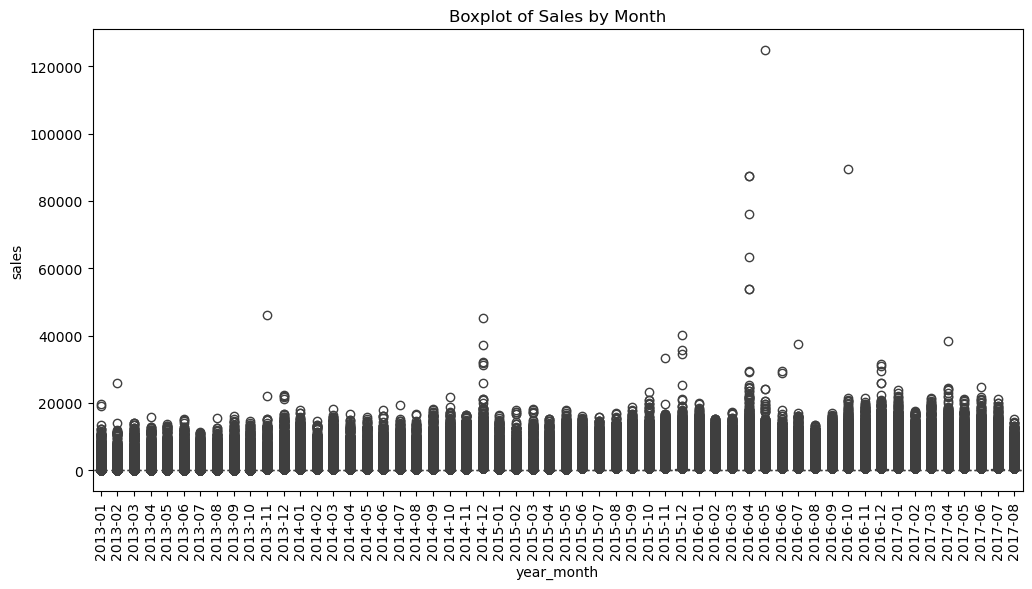

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

train_df['year_month'] = train_df['date'].dt.to_period('M')

#create a boxplot of sales by year_month
plt.figure(figsize=(12, 6))
sns.boxplot(x='year_month', y='sales', data=train_df)
plt.xticks(rotation=90)
plt.title('Boxplot of Sales by Month')
plt.show()

# EDA

In [23]:
print("Missing values in train_df:")
print(train_df.isnull().sum())

print("\nMissing values in test_df:")
print(test_df.isnull().sum())

Missing values in train_df:
id                       0
date                     0
store_nbr                0
family                   0
sales                    0
onpromotion              0
year                     0
month                    0
day                      0
day_of_week              0
week_of_year             0
lag_1                 1782
lag_7                12474
rolling_mean_7       10692
rolling_mean_30      51678
city                     0
state                    0
store_type               0
cluster                  0
dcoilwtico          878526
holiday_type       2551824
has_promotion            0
year_month               0
dtype: int64

Missing values in test_df:
id                    0
date                  0
store_nbr             0
family                0
onpromotion           0
year                  0
month                 0
day                   0
day_of_week           0
week_of_year          0
lag_1                 0
lag_7                 0
rolling_mean_7        

In [24]:
#fill missing "dcoilwtico" in train_df by linear interpolation, forward fill, and backward fill
train_df['dcoilwtico'] = train_df['dcoilwtico'].interpolate(method='linear')
train_df['dcoilwtico'] = train_df['dcoilwtico'].ffill().bfill()

test_df['dcoilwtico'] = test_df['dcoilwtico'].interpolate(method='linear')
test_df['dcoilwtico'] = test_df['dcoilwtico'].ffill().bfill()

print(train_df['dcoilwtico'].isnull().sum())
print(test_df['dcoilwtico'].isnull().sum())

0
0


In [25]:
train_df['holiday_type'].fillna('No Holiday', inplace=True)
test_df['holiday_type'].fillna('No Holiday', inplace=True)
print(train_df['holiday_type'].isnull().sum())
print(test_df['holiday_type'].isnull().sum())

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/2716770058.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['holiday_type'].fillna('No Holiday', inplace=True)
/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/2716770058.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

0
0


In [26]:
train_df[['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30']] = train_df[['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30']].ffill().bfill()
#test_df[['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30']] = test_df[['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30']].ffill().bfill()

# Apply mean imputation only to numeric columns with NaN values
numeric_columns_with_nan = ['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30']

#Impute missing values with mean
train_df[numeric_columns_with_nan] = train_df[numeric_columns_with_nan].fillna(train_df[numeric_columns_with_nan].mean())
#test_df[numeric_columns_with_nan] = test_df[numeric_columns_with_nan].fillna(test_df[numeric_columns_with_nan].mean())

In [27]:
print("Missing values in train_df:")
print(train_df.isnull().sum())

print("\nMissing values in test_df:")
print(test_df.isnull().sum())

Missing values in train_df:
id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
year               0
month              0
day                0
day_of_week        0
week_of_year       0
lag_1              0
lag_7              0
rolling_mean_7     0
rolling_mean_30    0
city               0
state              0
store_type         0
cluster            0
dcoilwtico         0
holiday_type       0
has_promotion      0
year_month         0
dtype: int64

Missing values in test_df:
id                 0
date               0
store_nbr          0
family             0
onpromotion        0
year               0
month              0
day                0
day_of_week        0
week_of_year       0
lag_1              0
lag_7              0
rolling_mean_7     0
rolling_mean_30    0
city               0
state              0
store_type         0
cluster            0
dcoilwtico         0
holiday_type       0
has_promotion      0
dtype: 

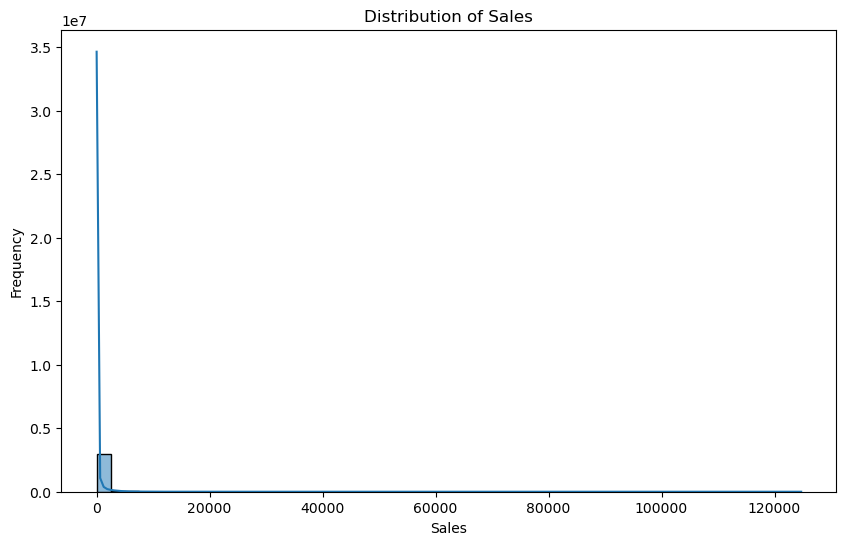

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

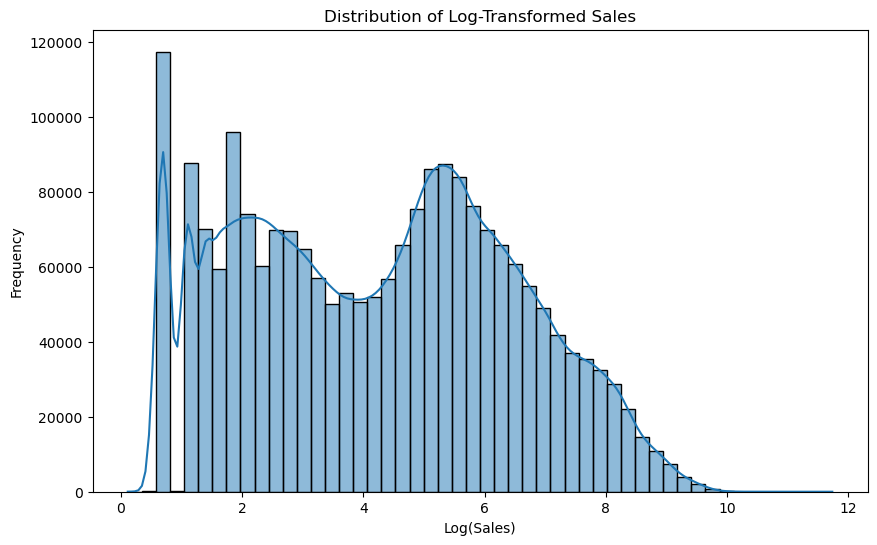

In [29]:
#use log for better distribution
train_df['log_sales'] = np.log1p(train_df['sales'])

#check for any inf or NaN values after the transformation
train_df = train_df.replace([np.inf, -np.inf], np.nan)
train_df = train_df.dropna(subset=['log_sales'])

#filter out small sales
train_df = train_df[train_df['sales'] > 0]


plt.figure(figsize=(10, 6))
sns.histplot(train_df['log_sales'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Sales')
plt.xlabel('Log(Sales)')
plt.ylabel('Frequency')
plt.show()

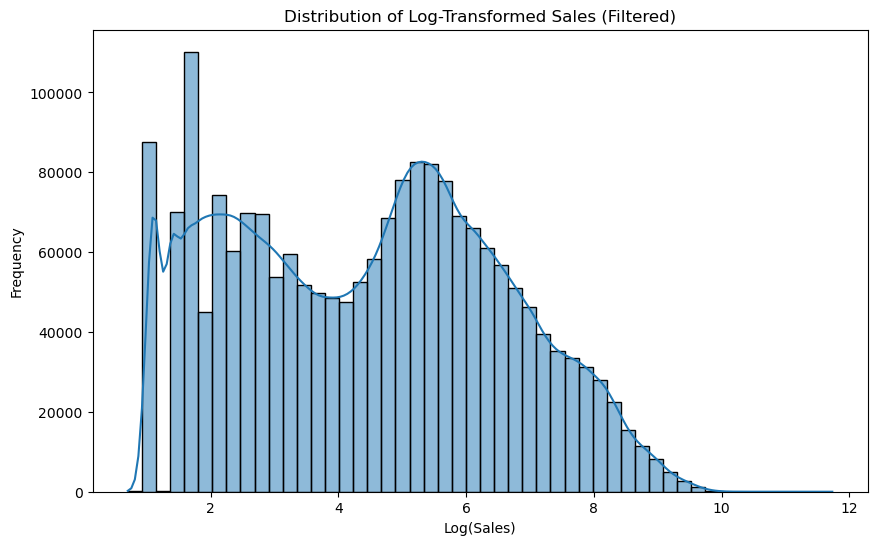

In [30]:
#filter out less small sales
train_df = train_df[train_df['sales'] > 1]

plt.figure(figsize=(10, 6))
sns.histplot(train_df['log_sales'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Sales (Filtered)')
plt.xlabel('Log(Sales)')
plt.ylabel('Frequency')
plt.show()

There are still a lot of small values. There is a peak at 6, which is equal to 403 units sold. Then the tail drops which is expected indicating larger sales are rarer.

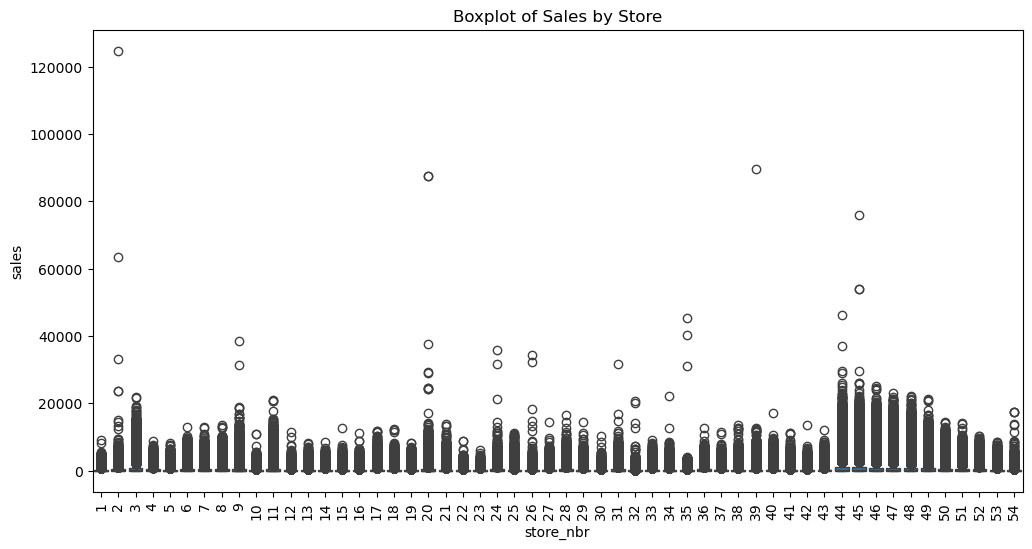

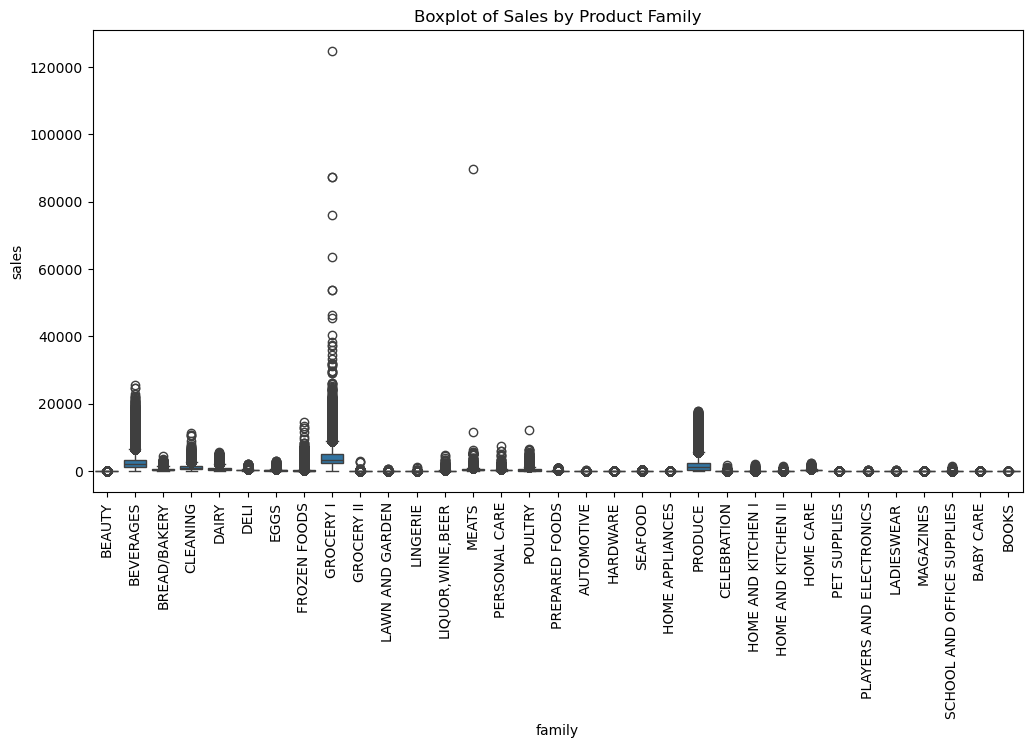

In [31]:
#boxplot of sales by store_nbr
plt.figure(figsize=(12, 6))
sns.boxplot(x='store_nbr', y='sales', data=train_df)
plt.title('Boxplot of Sales by Store')
plt.xticks(rotation=90)
plt.show()

#boxplot of sales by family
plt.figure(figsize=(12, 6))
sns.boxplot(x='family', y='sales', data=train_df)
plt.title('Boxplot of Sales by Product Family')
plt.xticks(rotation=90)
plt.show()

2nd graph: Low median, likely that most sales are concentrated in a few key families. There are some outliers in Meats, Poultry. 


1st graph: Stores 44 to 49 have the biggest sales. Low median. Lots of outliers for different stores, maybe promotions, or holidays.


In [32]:
top_stores_info = stores_df[stores_df['store_nbr'].isin([44, 45, 46, 47, 48, 49])]

#print the relevant information for top stores
print("Information for Stores 44, 45, 46, 47, 48, 49:")
print(top_stores_info[['store_nbr', 'city', 'state', 'type', 'cluster']])

Information for Stores 44, 45, 46, 47, 48, 49:
    store_nbr   city      state type  cluster
43         44  Quito  Pichincha    A        5
44         45  Quito  Pichincha    A       11
45         46  Quito  Pichincha    A       14
46         47  Quito  Pichincha    A       14
47         48  Quito  Pichincha    A       14
48         49  Quito  Pichincha    A       11


The stores with the most sales are located in the capital city of Ecuador.

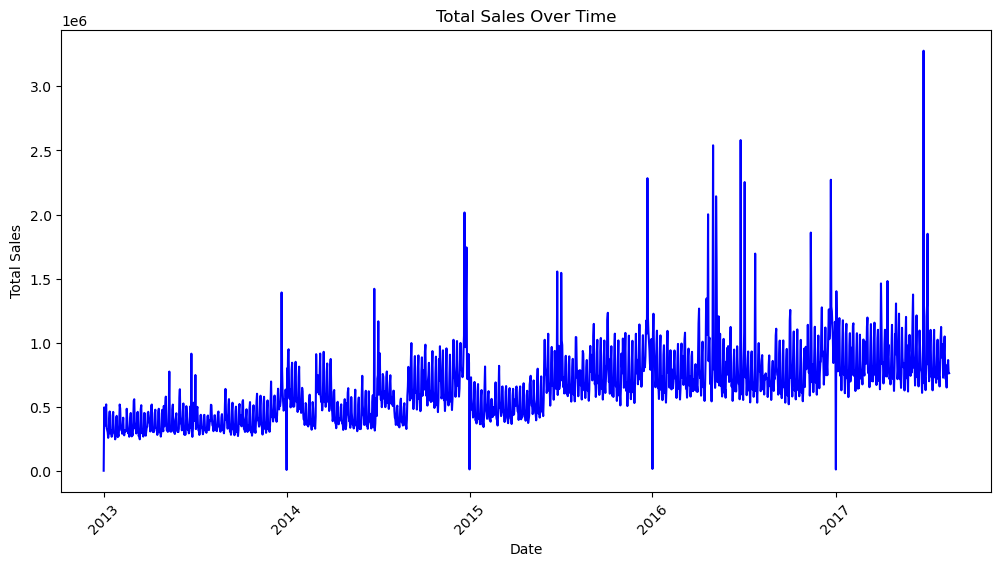

In [33]:
sales_by_date = train_df.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(sales_by_date['date'], sales_by_date['sales'], color='blue')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

There are some big spikes in the graph, indicating holidays/events. In April 2016 there was an earthquake in Ecuador, so there are some spikes there.

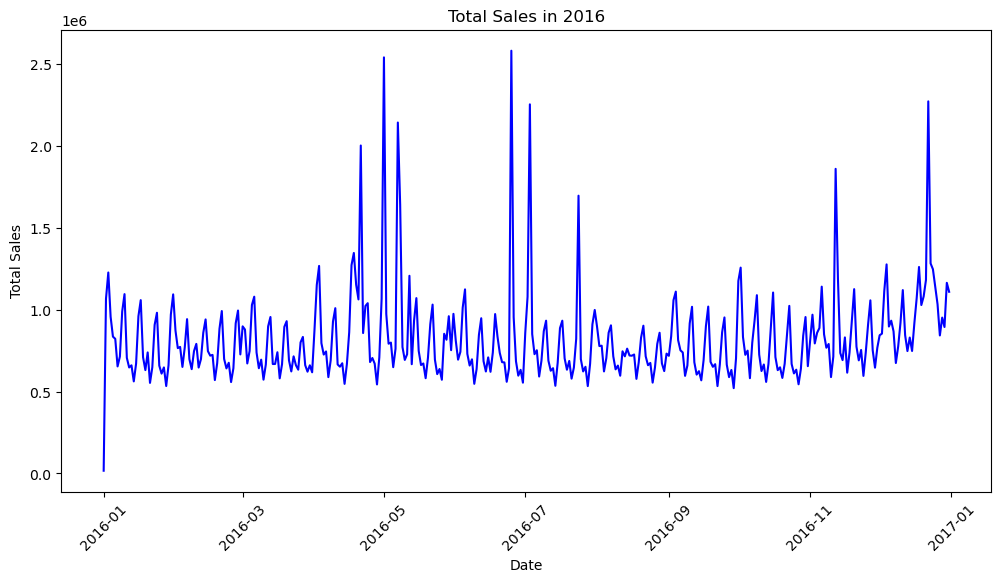

In [34]:
train_df['date'] = pd.to_datetime(train_df['date'])

#filter data for the year 2016
train_2016 = train_df[train_df['date'].dt.year == 2016]

#group by date and sum the sales for each date in 2016
sales_by_date_2016 = train_2016.groupby('date')['sales'].sum().reset_index()

#plot the total sales over time for 2016
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date_2016['date'], sales_by_date_2016['sales'], color='blue')
plt.title('Total Sales in 2016')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

People bought so much stuff during the earthquake, to keep in stock or donate, that stores ran out of inventory.

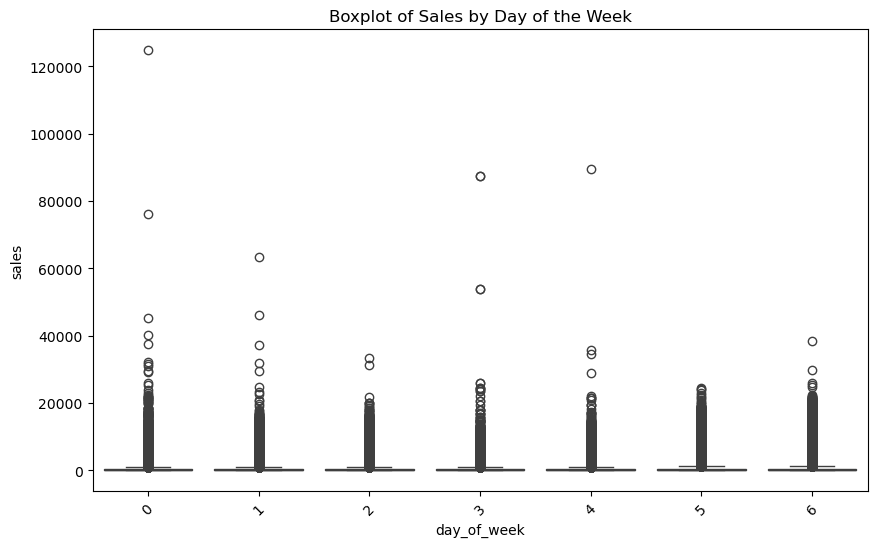

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='sales', data=train_df)
plt.title('Boxplot of Sales by Day of the Week')
plt.xticks(rotation=45)
plt.show()

Some days have very high outliers. The boxes for all days of the week are concentrated near the bottom of the plot, meaning most stores have relatively low sales on an average day. Monday and Sunday are the days with the most sales.

In [36]:
outliers_df = train_df[train_df['sales'] > 80000]

print(outliers_df[['date', 'day_of_week', 'sales']])

              date  day_of_week       sales
2171292 2016-04-21            3   87438.516
2171293 2016-04-21            3   87438.516
2194017 2016-05-02            0  124717.000
2488752 2016-10-07            4   89576.360


In [37]:
#option to remove all earthquake dates
#earthquake_dates = holidays_df[holidays_df['description'].str.contains('Terremoto')]['date']

#Remove rows from train/test that have a date in the earthquake_dates
#train_df = train_df[~train_df['date'].isin(earthquake_dates)]
#test_df = test_df[~test_df['date'].isin(earthquake_dates)]

# Confirm the rows have been removed
#print(f"Rows in train_df after removing earthquake dates: {train_df.shape[0]}")
#print(f"Rows in test_df after removing earthquake dates: {test_df.shape[0]}")

All the dates are close to the earthquake. We might need to analyze if we should remove the dates of the earthquake or not for our final analysis/model.

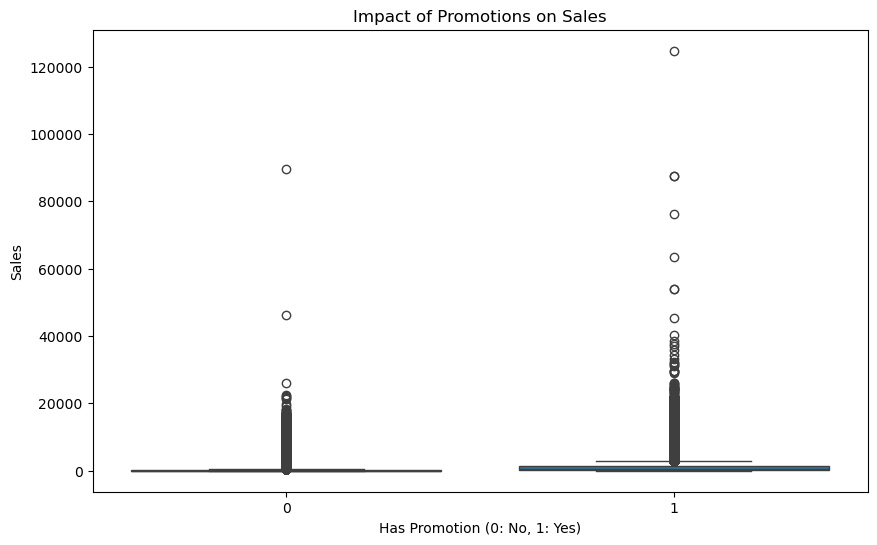

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='has_promotion', y='sales', data=train_df)
plt.title('Impact of Promotions on Sales')
plt.xlabel('Has Promotion (0: No, 1: Yes)')
plt.ylabel('Sales')
plt.show()

More variability during promotion. Fewer outliers during no promotion.

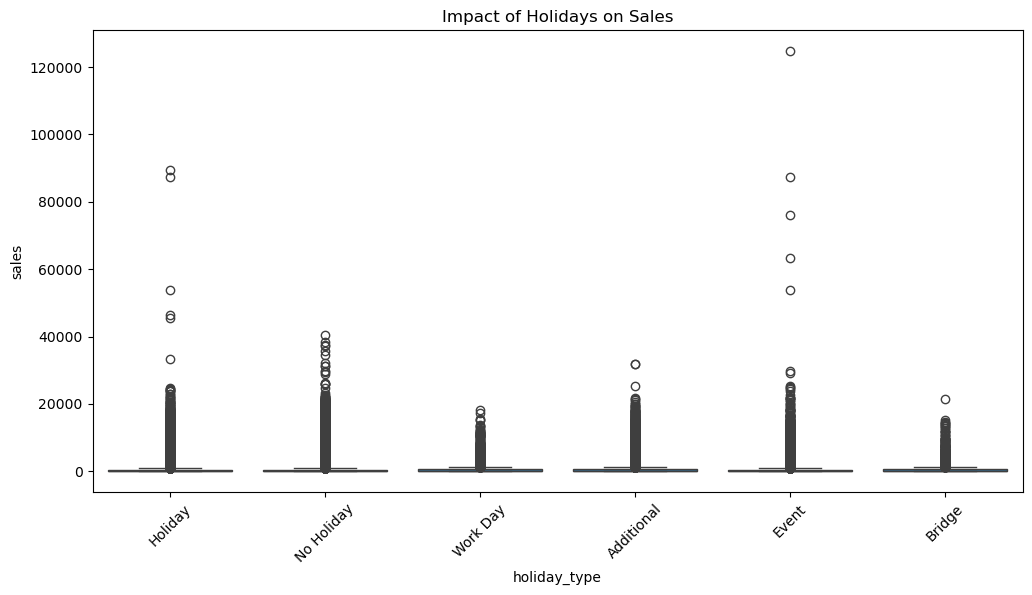

In [39]:
train_df['holiday_type'] = train_df['holiday_type'].replace('TransferredHoliday', 'Holiday')


plt.figure(figsize=(12, 6))
sns.boxplot(x='holiday_type', y='sales', data=train_df)
plt.title('Impact of Holidays on Sales')
plt.xticks(rotation=45)
plt.show()

In [40]:
outliers_h_df = train_df[train_df['sales'] > 40000]

print(outliers_h_df[['holiday_type', 'date', 'sales']])

        holiday_type       date       sales
569724       Holiday 2013-11-12   46271.000
1273284      Holiday 2014-12-08   45361.000
1941534   No Holiday 2015-12-14   40351.460
2166429        Event 2016-04-18   76090.000
2171292      Holiday 2016-04-21   87438.516
2171293        Event 2016-04-21   87438.516
2173074      Holiday 2016-04-21   53874.000
2173075        Event 2016-04-21   53874.000
2181543        Event 2016-04-26   63434.000
2194017        Event 2016-05-02  124717.000
2488752      Holiday 2016-10-07   89576.360


Lots of spikes on Holiday and Event days, indicating higher sales potential. Top 7 outliers in sales ocurred during the earthquake of 2016

In [41]:
train_df.dtypes

id                          int64
date               datetime64[ns]
store_nbr                   int64
family                     object
sales                     float64
onpromotion                 int64
year                        int32
month                       int32
day                         int32
day_of_week                 int32
week_of_year               UInt32
lag_1                     float64
lag_7                     float64
rolling_mean_7            float64
rolling_mean_30           float64
city                       object
state                      object
store_type                 object
cluster                     int64
dcoilwtico                float64
holiday_type               object
has_promotion               int64
year_month              period[M]
log_sales                 float64
dtype: object

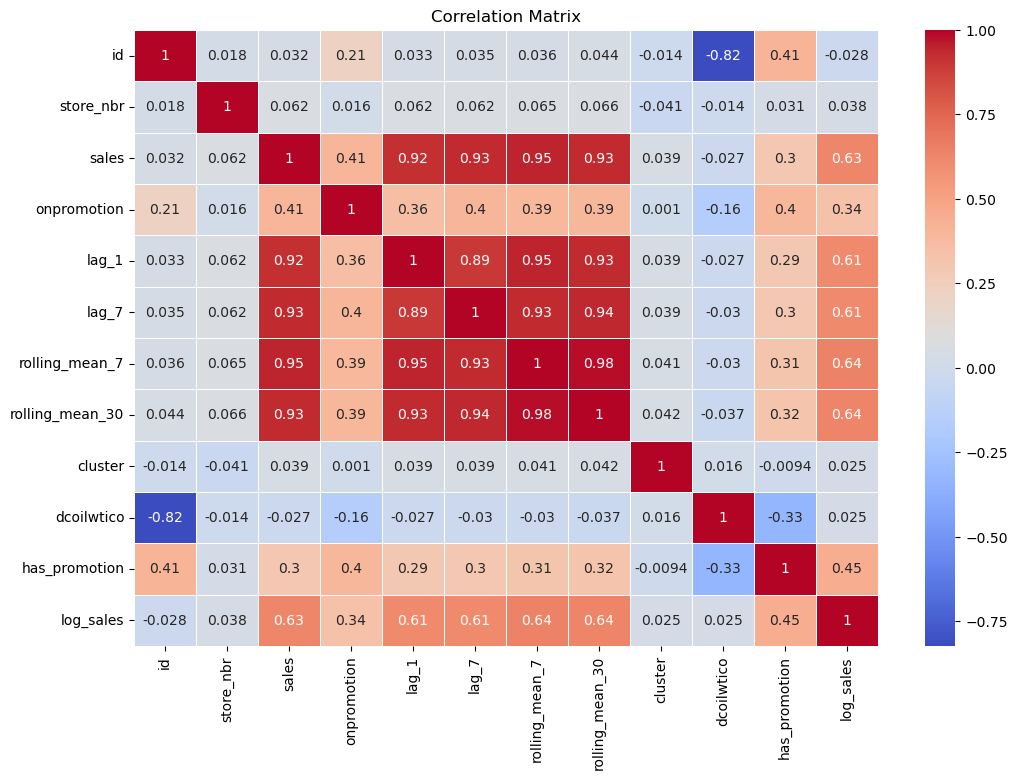

In [42]:
numeric_columns = train_df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = train_df[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Negative correlation between dcoil and has_promotion. Strong correlation between lags and rollings with sales.

In [43]:
pd.set_option('display.max_rows', None)
corr_pairs = corr_matrix.unstack().sort_values(ascending=False, key=abs)
corr_pairs = corr_pairs[corr_pairs < 1]
print(corr_pairs)

rolling_mean_7   rolling_mean_30    0.982860
rolling_mean_30  rolling_mean_7     0.982860
rolling_mean_7   lag_1              0.947660
lag_1            rolling_mean_7     0.947660
rolling_mean_7   sales              0.945194
sales            rolling_mean_7     0.945194
lag_7            rolling_mean_30    0.937816
rolling_mean_30  lag_7              0.937816
rolling_mean_7   lag_7              0.934532
lag_7            rolling_mean_7     0.934532
                 sales              0.932699
sales            lag_7              0.932699
lag_1            rolling_mean_30    0.931691
rolling_mean_30  lag_1              0.931691
sales            rolling_mean_30    0.931025
rolling_mean_30  sales              0.931025
sales            lag_1              0.915447
lag_1            sales              0.915447
lag_7            lag_1              0.894962
lag_1            lag_7              0.894962
dcoilwtico       id                -0.822874
id               dcoilwtico        -0.822874
log_sales 

I would like to consider transforming other column types (city, family, state, store_type, holiday_type) into numeric, to explore relationships.

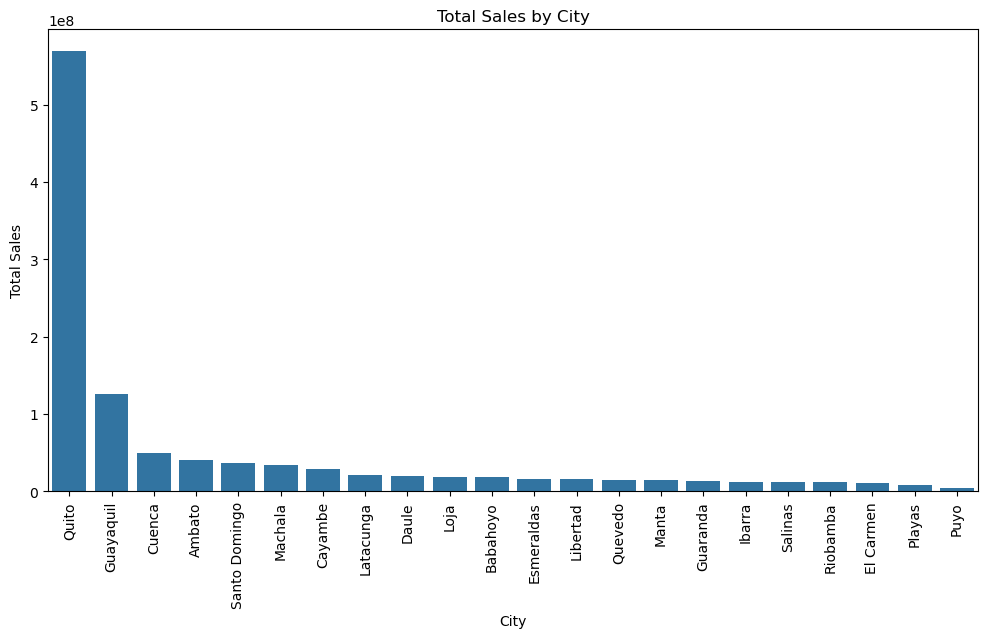

In [44]:
sales_by_city = train_df.groupby('city')['sales'].sum().reset_index()

#sort cities by total sales
sales_by_city = sales_by_city.sort_values(by='sales', ascending=False)

#plot total sales by city
plt.figure(figsize=(12, 6))
sns.barplot(x='city', y='sales', data=sales_by_city)
plt.xticks(rotation=90)
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.show()

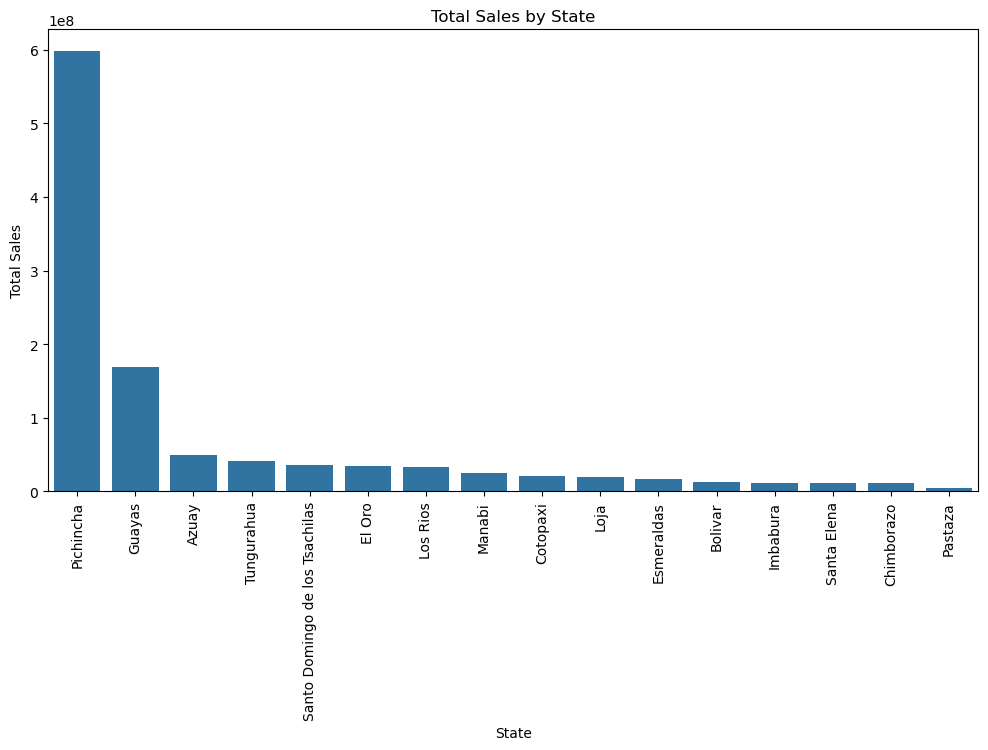

In [45]:
sales_by_state = train_df.groupby('state')['sales'].sum().reset_index()

#sort states by total sales
sales_by_state = sales_by_state.sort_values(by='sales', ascending=False)

#plot total sales by state
plt.figure(figsize=(12, 6))
sns.barplot(x='state', y='sales', data=sales_by_state)
plt.xticks(rotation=90)
plt.title('Total Sales by State')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.show()

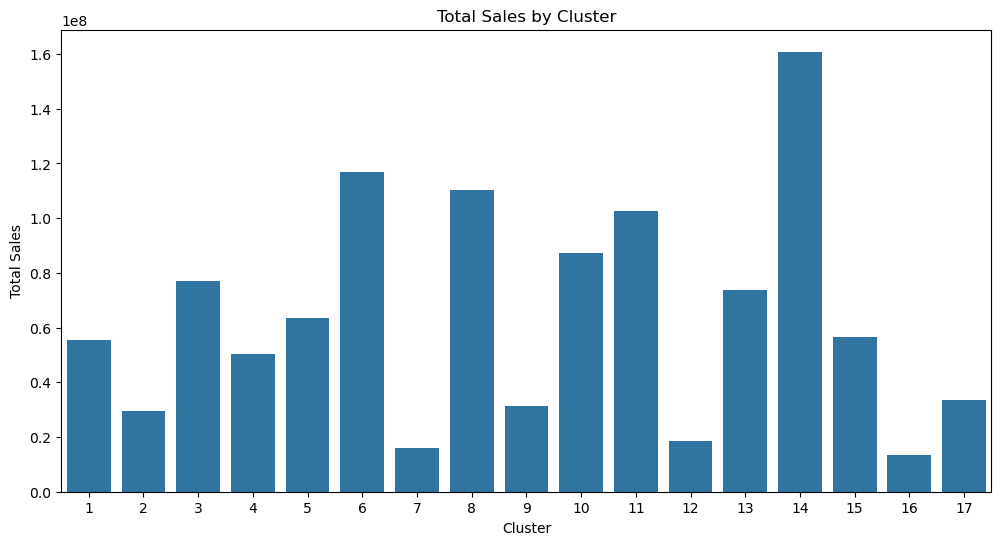

In [46]:
sales_by_cluster = train_df.groupby('cluster')['sales'].sum().reset_index()

#sort clusters by total sales
sales_by_cluster = sales_by_cluster.sort_values(by='sales', ascending=False)

#plot total sales by cluster
plt.figure(figsize=(12, 6))
sns.barplot(x='cluster', y='sales', data=sales_by_cluster)
plt.title('Total Sales by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.show()

/opt/anaconda3/envs/test/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


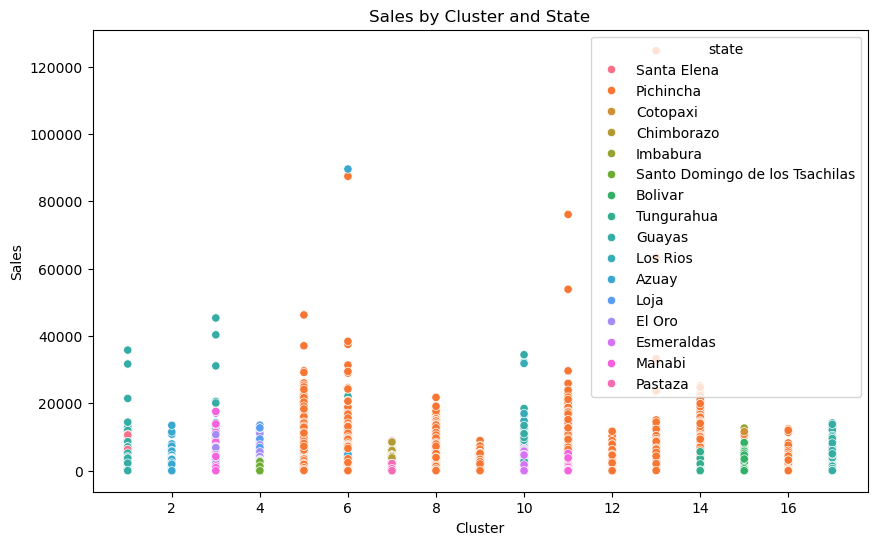

In [47]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cluster', y='sales', hue='state', data=train_df)
plt.title('Sales by Cluster and State')
plt.xlabel('Cluster')
plt.ylabel('Sales')
plt.show()

In [48]:
print("Columns in train_df:", train_df.columns)
print("Columns in test_df:", test_df.columns)

Columns in train_df: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'store_type',
       'cluster', 'dcoilwtico', 'holiday_type', 'has_promotion', 'year_month',
       'log_sales'],
      dtype='object')
Columns in test_df: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'year', 'month',
       'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'store_type',
       'cluster', 'dcoilwtico', 'holiday_type', 'has_promotion'],
      dtype='object')


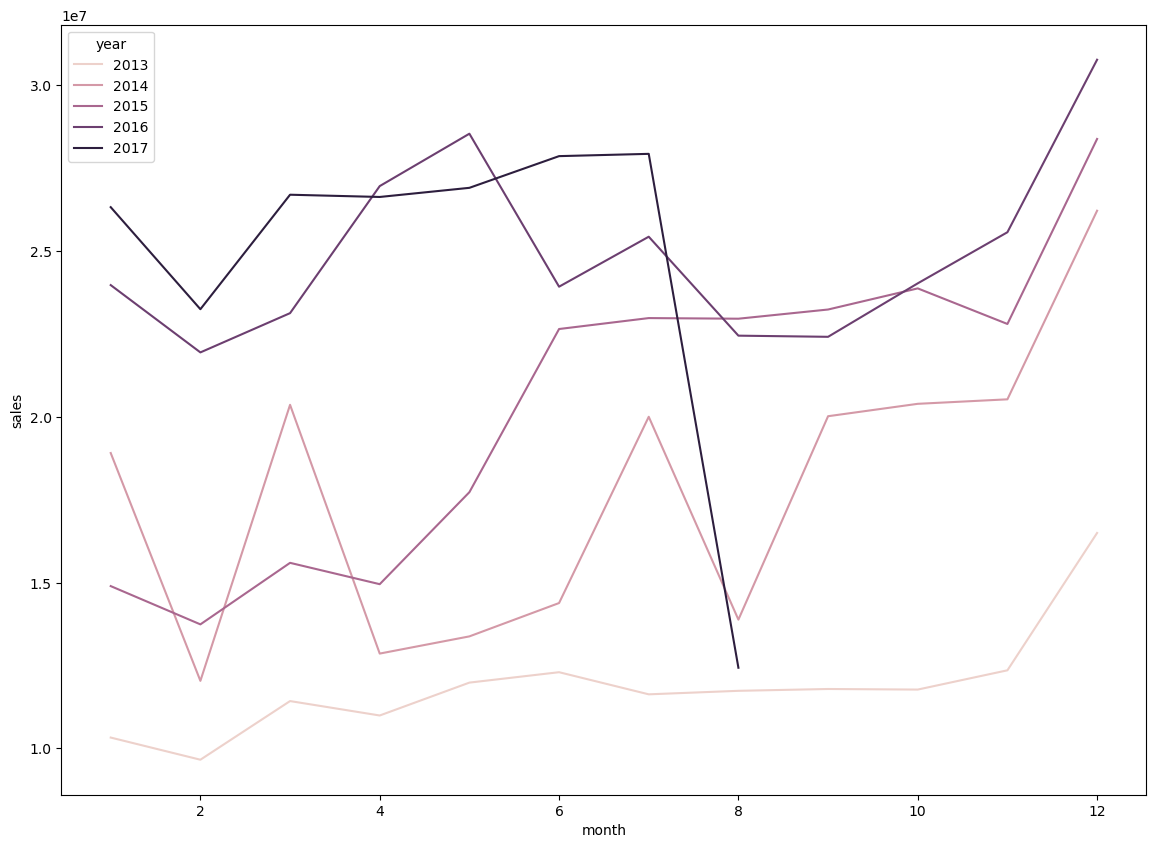

In [49]:
month_sales_group = train_df.groupby(by=['year', 'month'])['sales'].sum()
pd.DataFrame(month_sales_group)
# 绘制图表
# Draw a chart
plt.figure(figsize=(14, 10))
ax = sns.lineplot(pd.DataFrame(month_sales_group), x='month', y='sales', hue='year')
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [50]:
# Remove the columns 'log_sales' and 'year_month'
train_df = train_df.drop(['log_sales', 'year_month'], axis=1)

# Filter out rows before 2015
train_df = train_df[train_df['year'] >= 2015]

# Preprocessing and Modeling

In [51]:
# Check for any remaining NaNs
print(train_df.isnull().sum())
print(test_df.isnull().sum())
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
year               0
month              0
day                0
day_of_week        0
week_of_year       0
lag_1              0
lag_7              0
rolling_mean_7     0
rolling_mean_30    0
city               0
state              0
store_type         0
cluster            0
dcoilwtico         0
holiday_type       0
has_promotion      0
dtype: int64
id                 0
date               0
store_nbr          0
family             0
onpromotion        0
year               0
month              0
day                0
day_of_week        0
week_of_year       0
lag_1              0
lag_7              0
rolling_mean_7     0
rolling_mean_30    0
city               0
state              0
store_type         0
cluster            0
dcoilwtico         0
holiday_type       0
has_promotion      0
dtype: int64


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')
warnings.filterwarnings("ignore", category=ValueWarning)

In [52]:
train_df = train_df.groupby(by=['date', 'family'])[['sales', 'onpromotion']].sum().reset_index()
train_df.index = train_df['date']

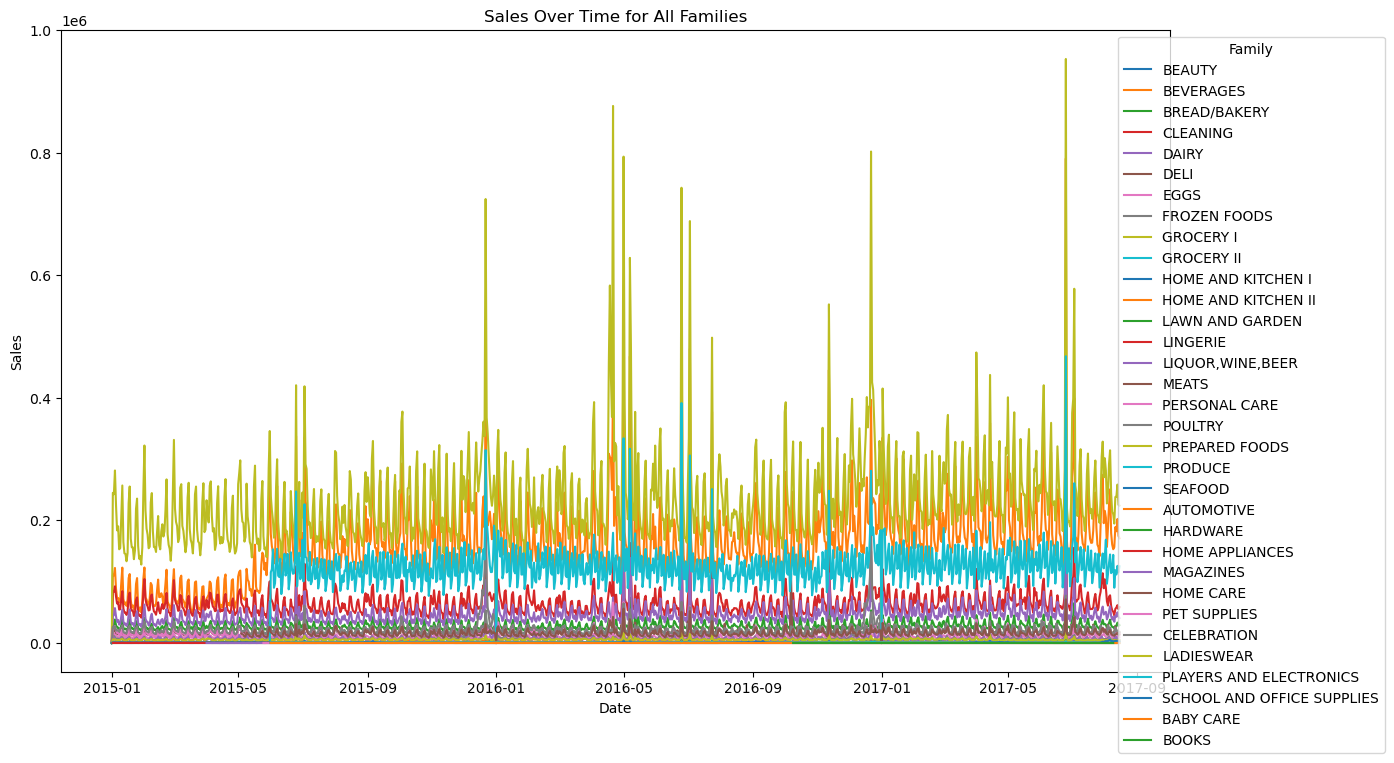

In [64]:
families = train_df_copy['family'].unique()

plt.figure(figsize=(14, 8))

# Loop through each family and plot the sales on the same plot
for family in families:
    family_df = train_df[train_df['family'] == family]
    plt.plot(family_df['date'], family_df['sales'], label=family)

# Add title and labels
plt.title('Sales Over Time for All Families')
plt.xlabel('Date')
plt.ylabel('Sales')

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), title="Family")

plt.tight_layout()
plt.show()

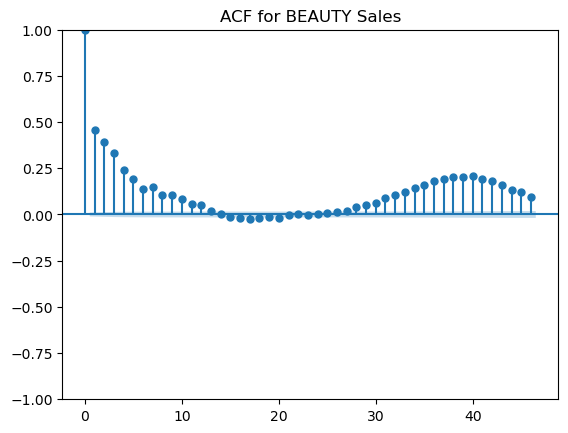

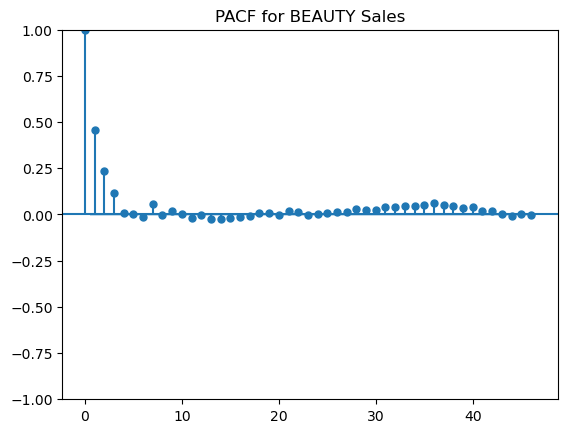

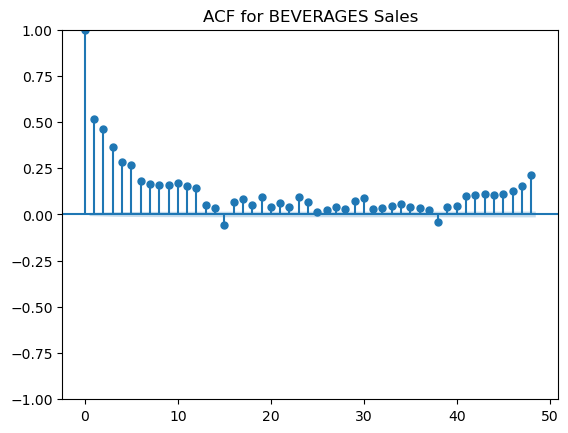

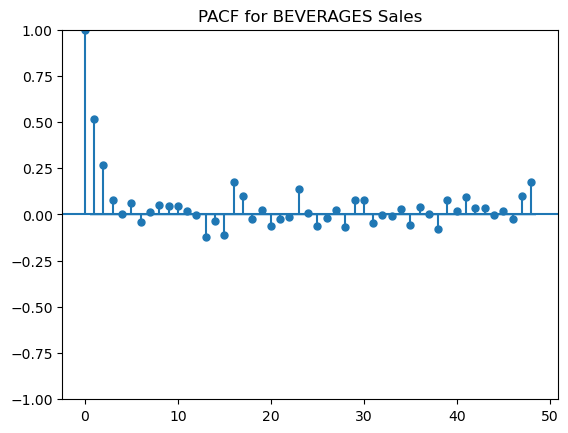

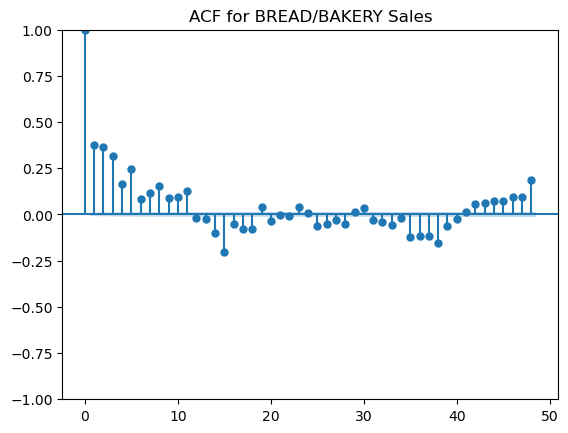

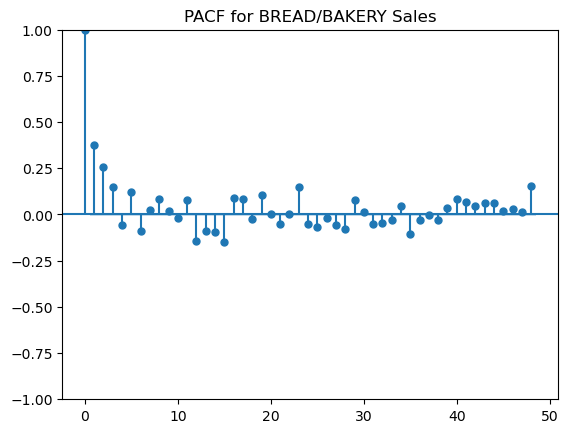

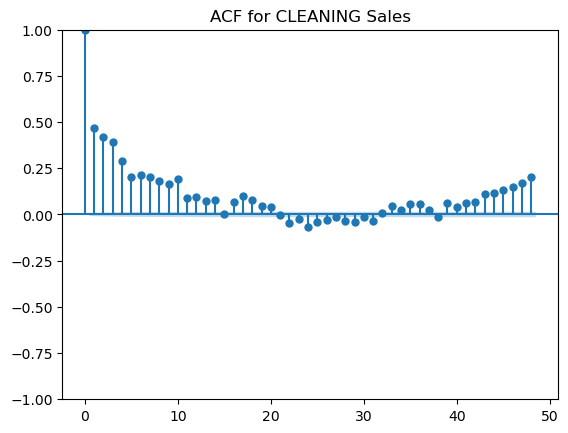

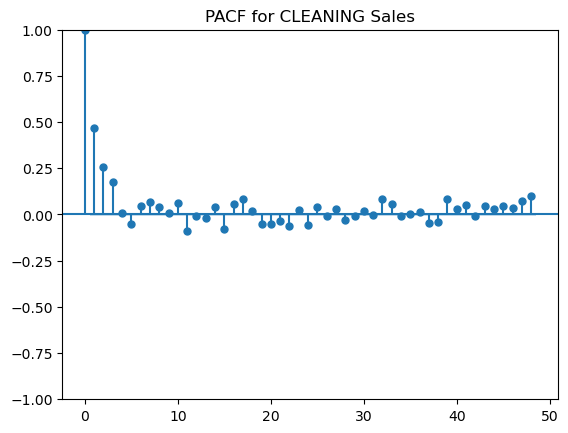

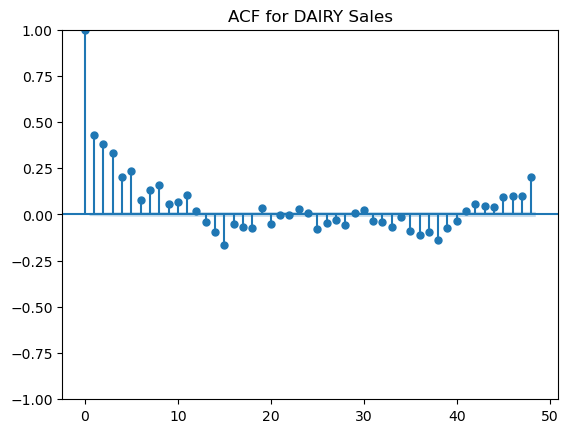

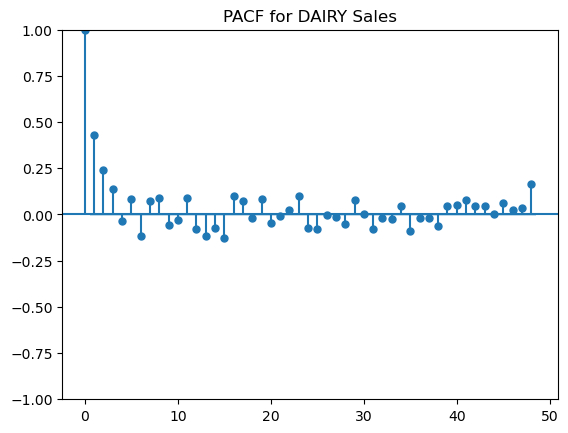

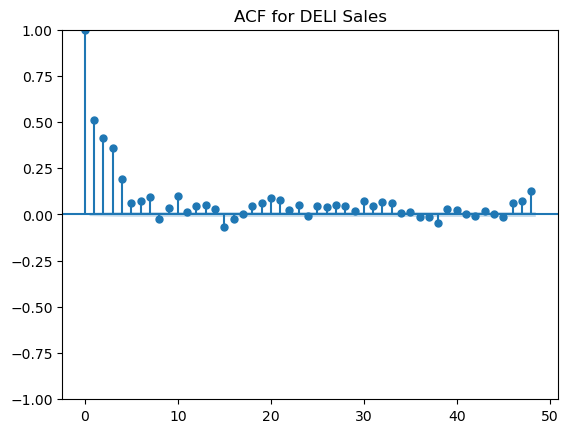

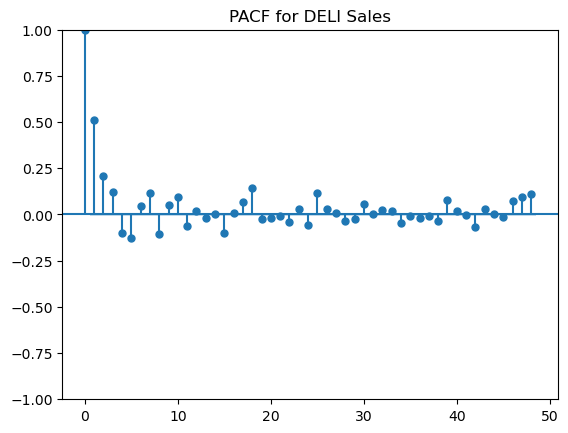

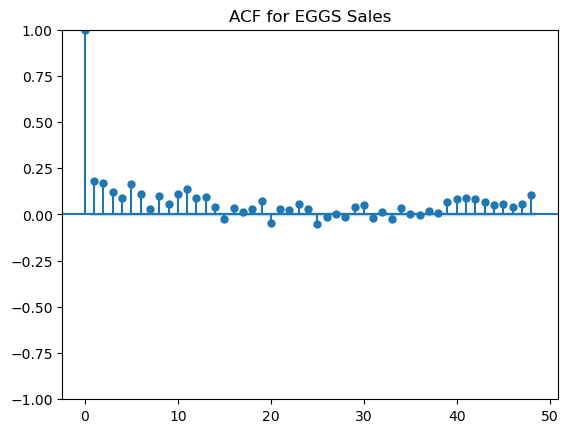

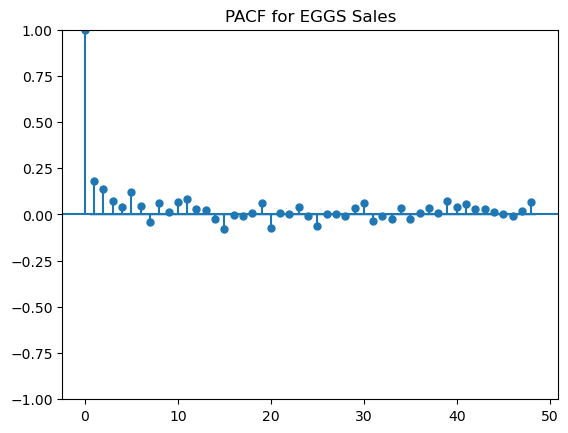

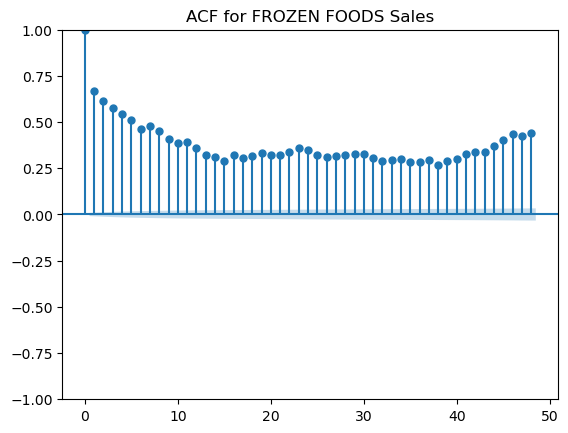

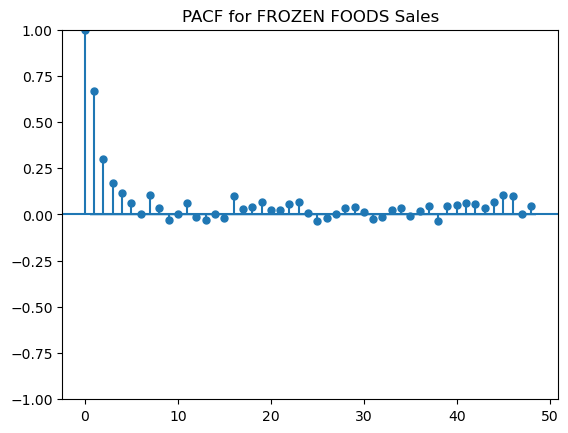

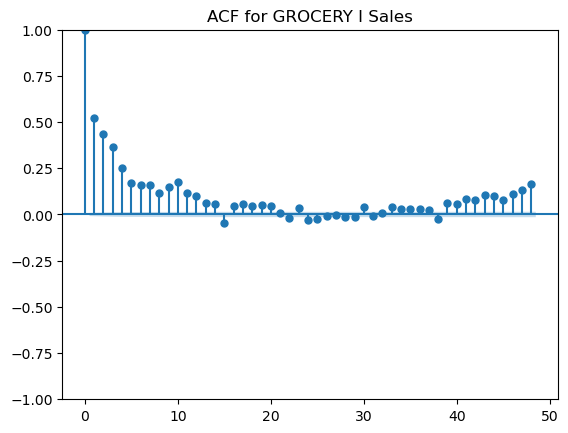

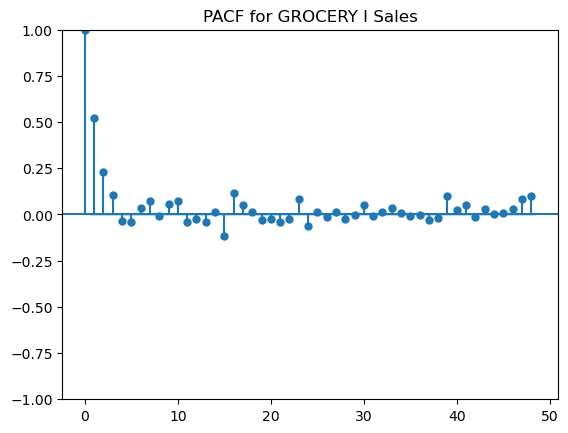

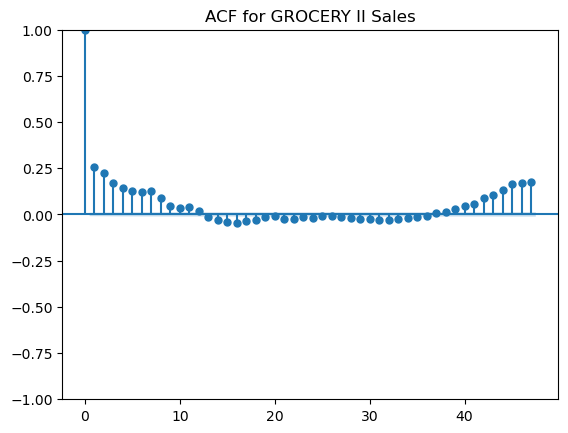

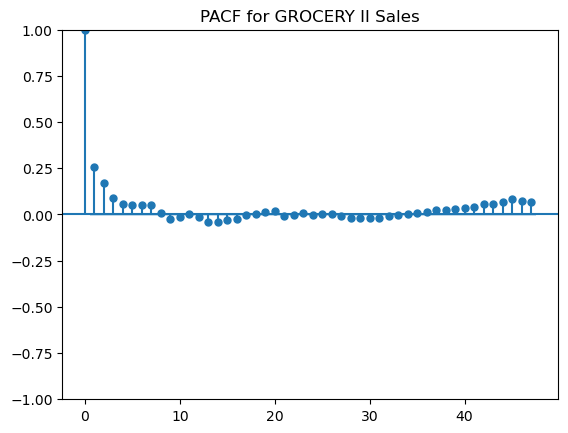

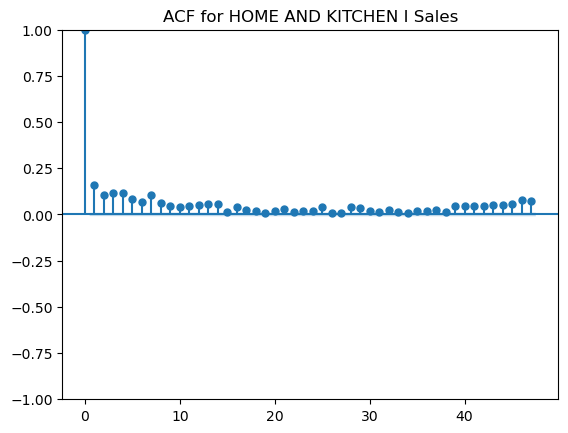

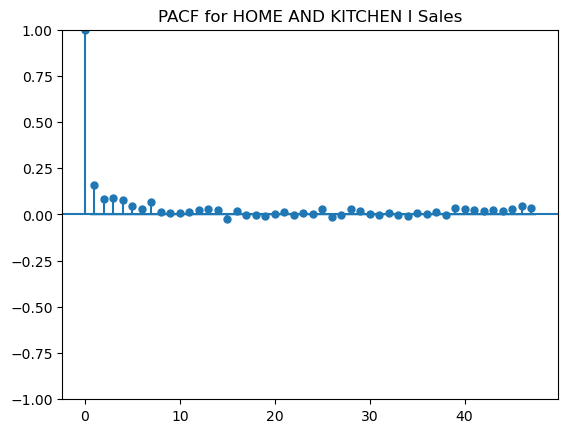

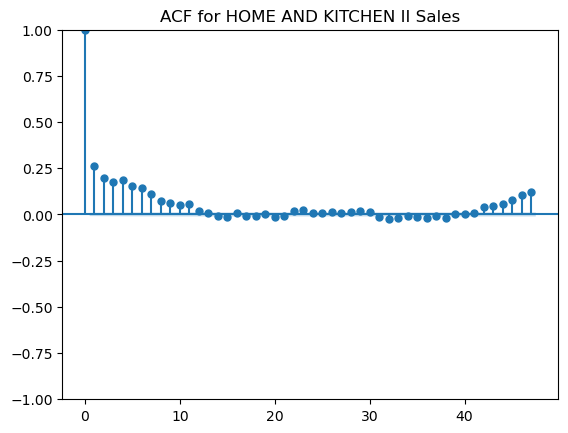

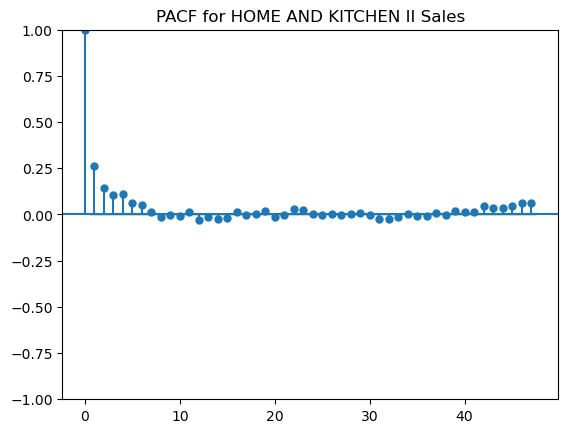

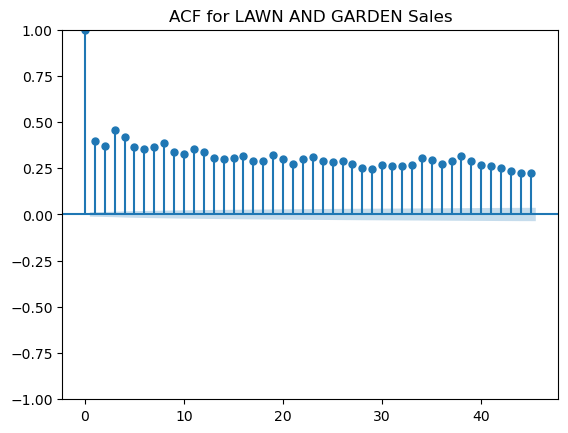

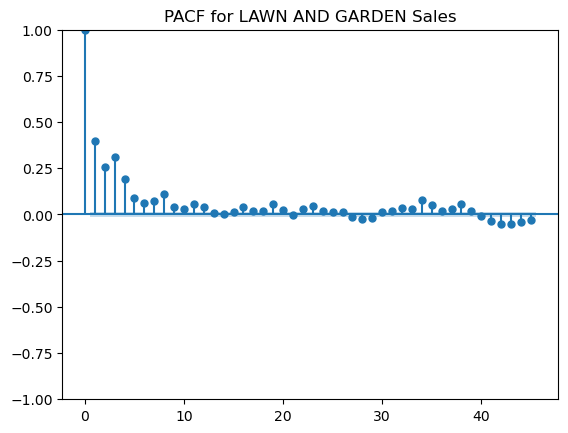

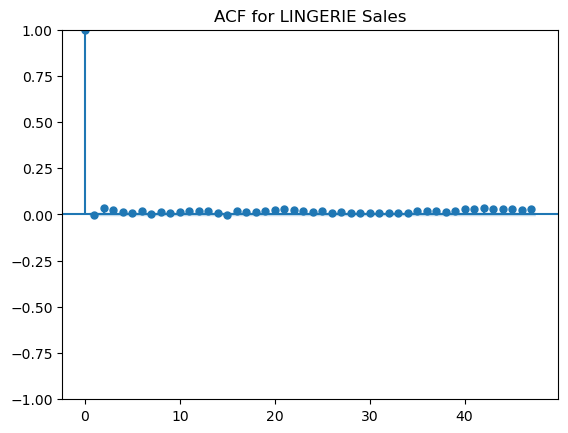

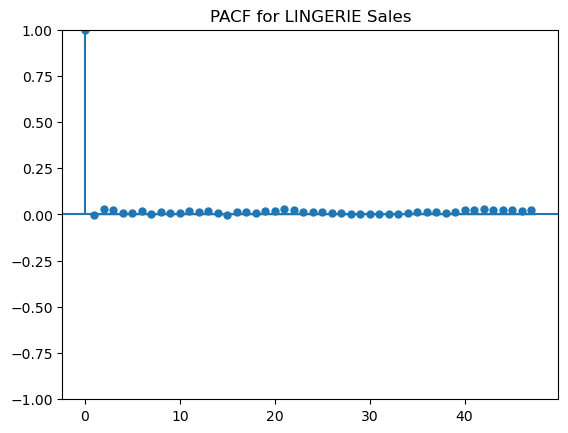

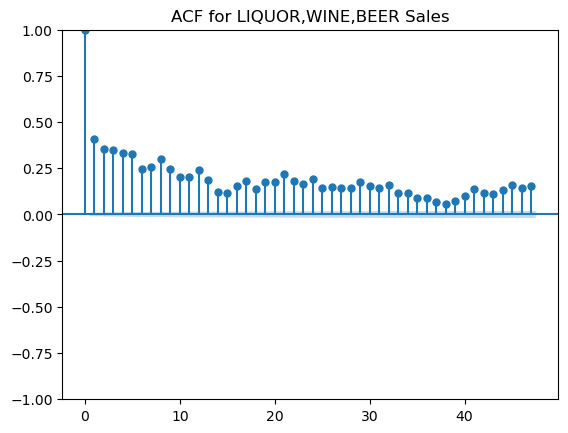

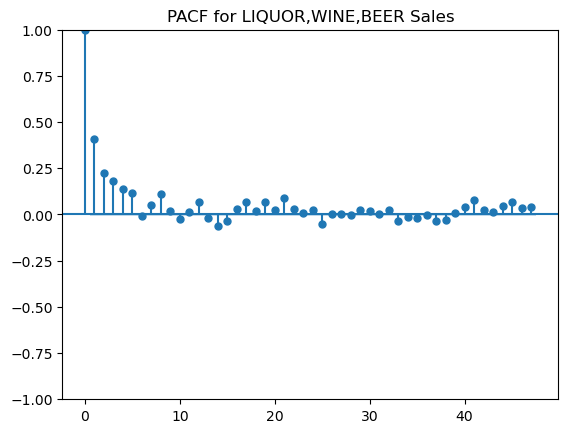

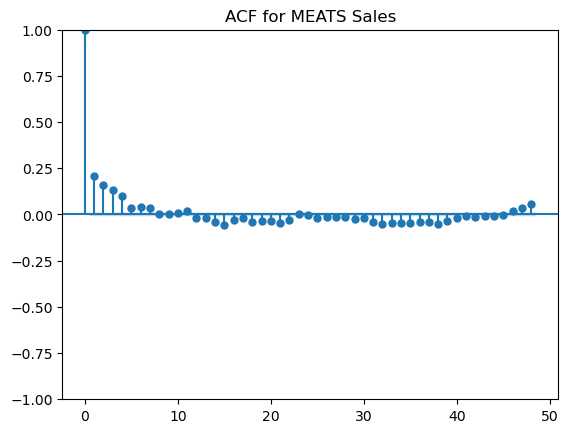

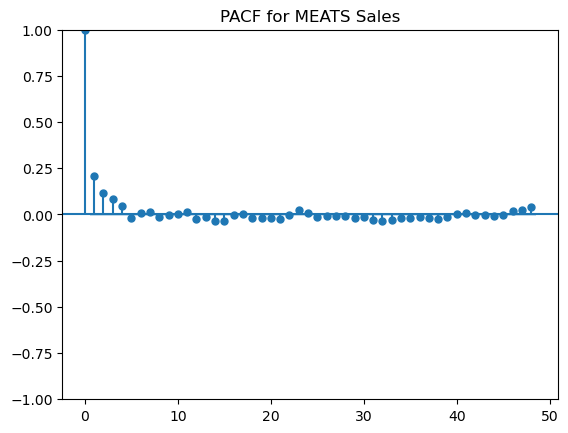

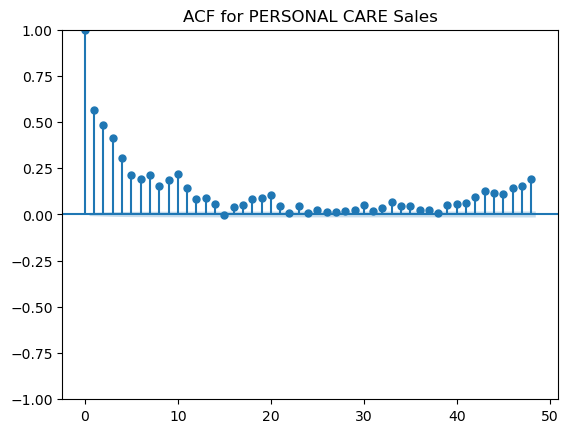

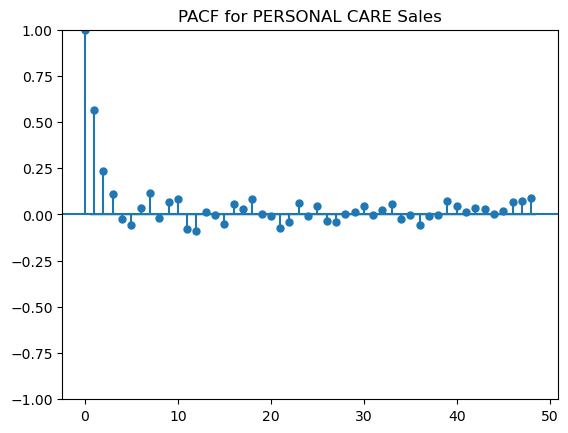

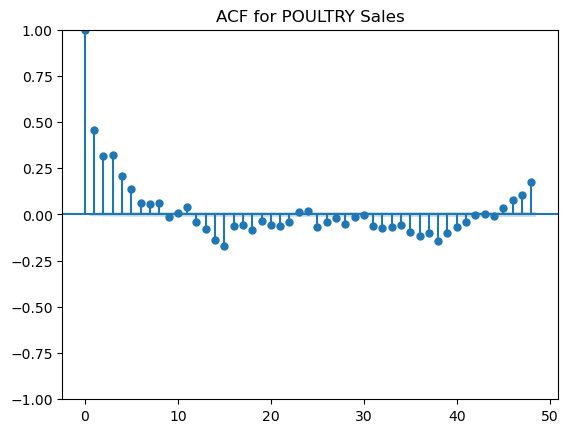

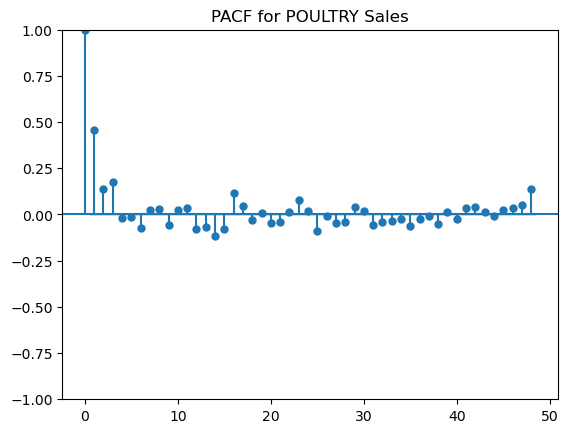

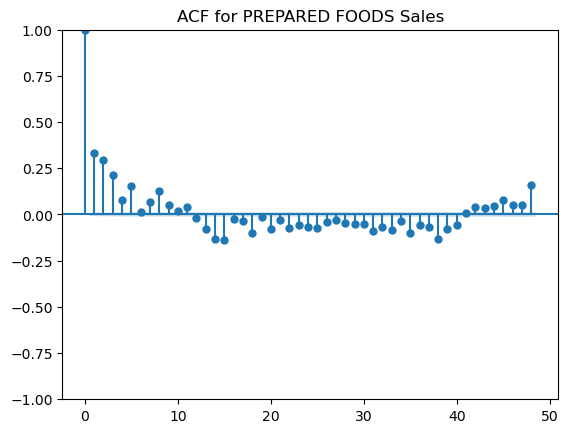

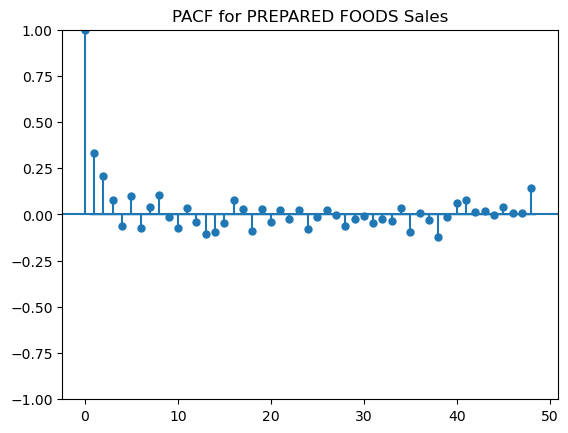

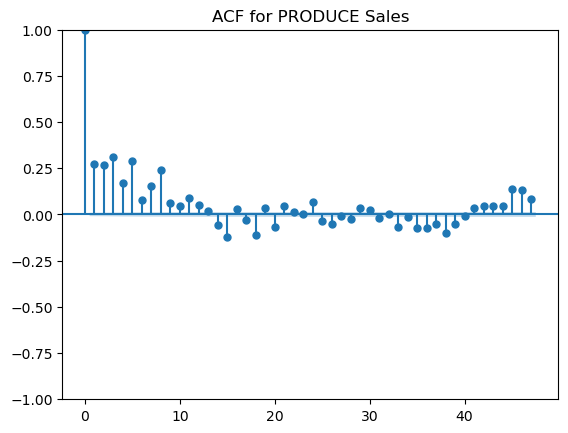

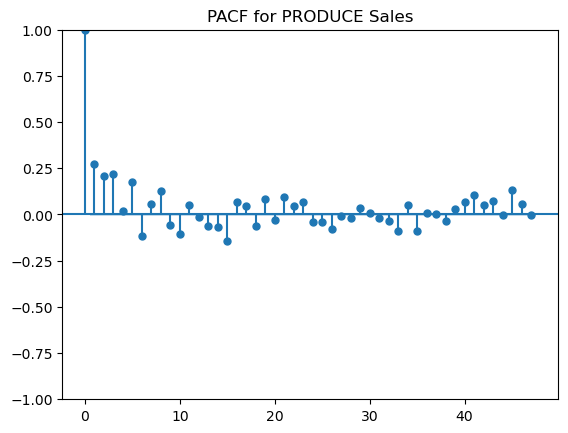

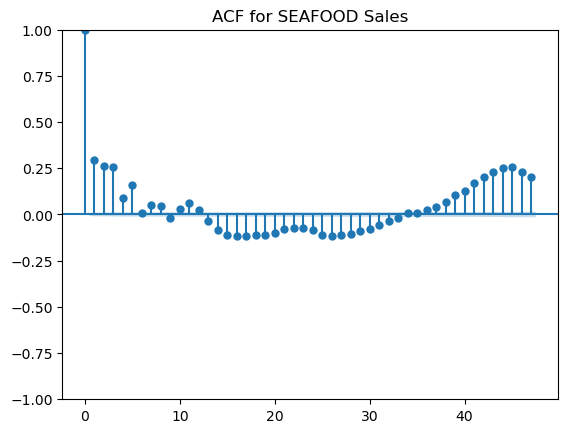

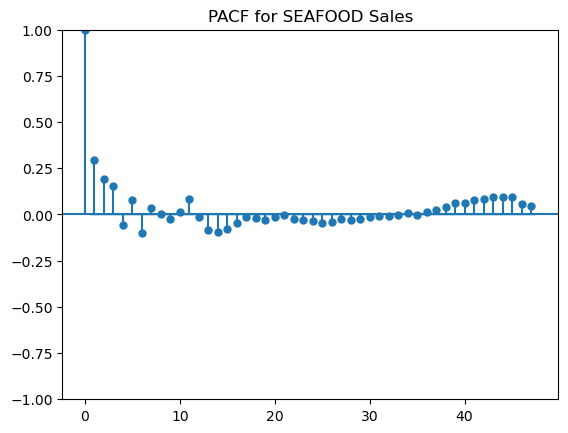

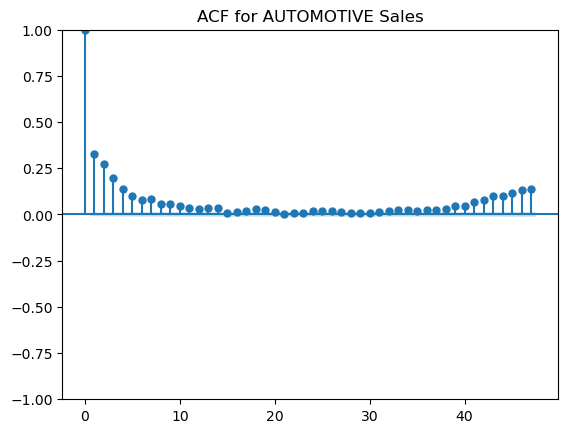

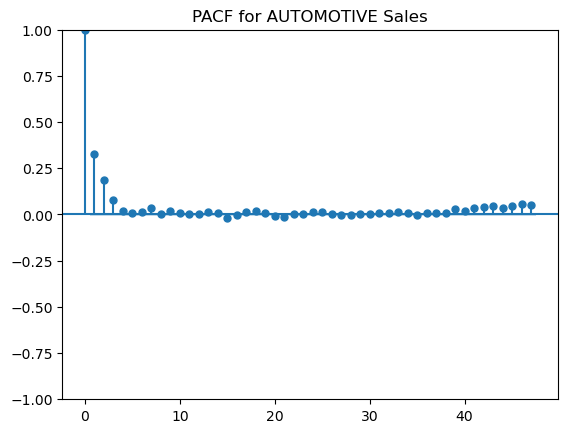

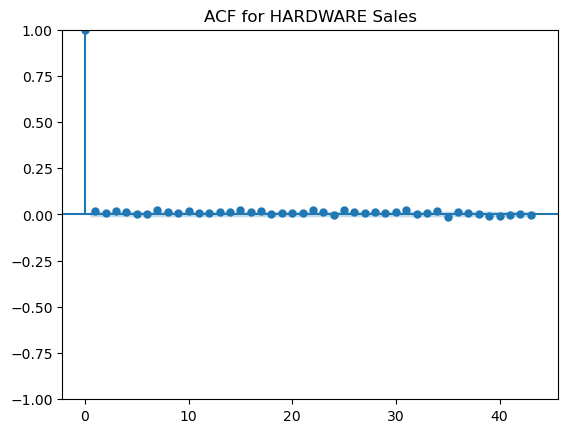

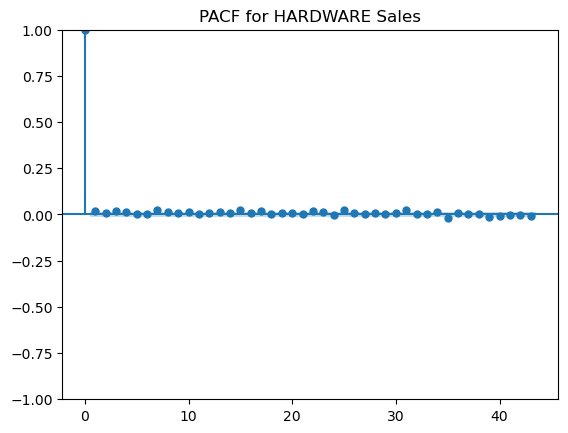

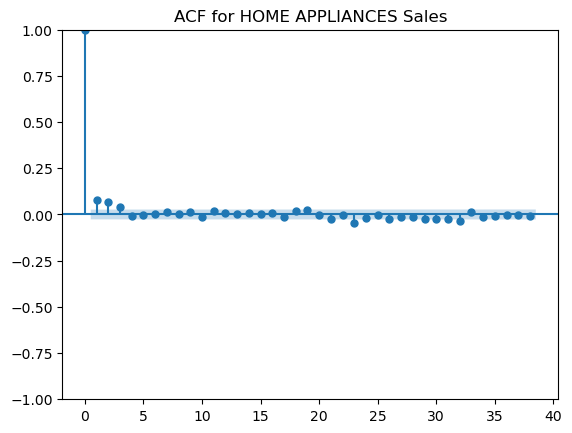

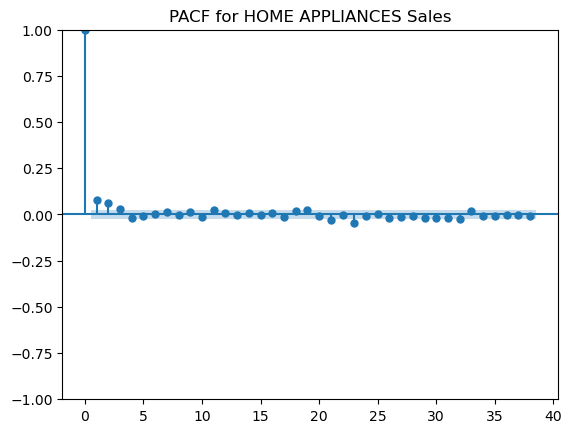

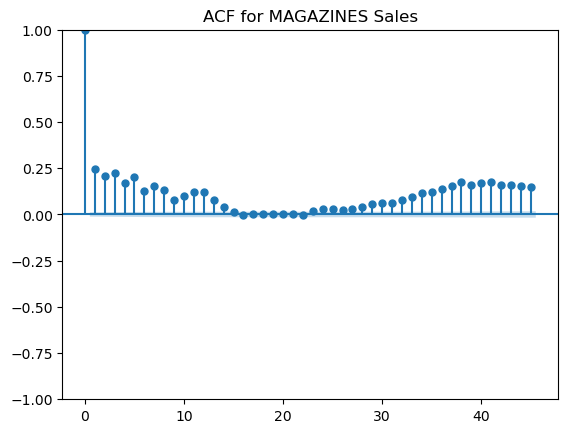

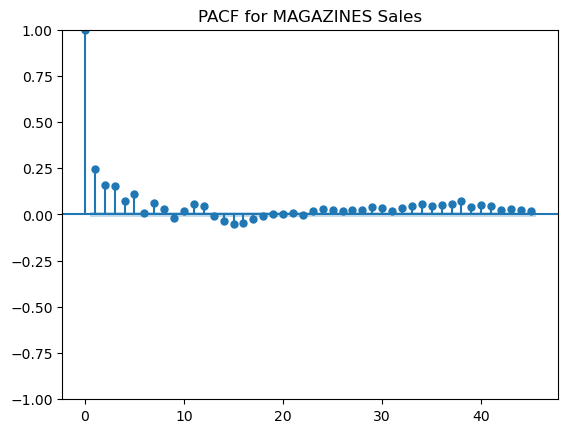

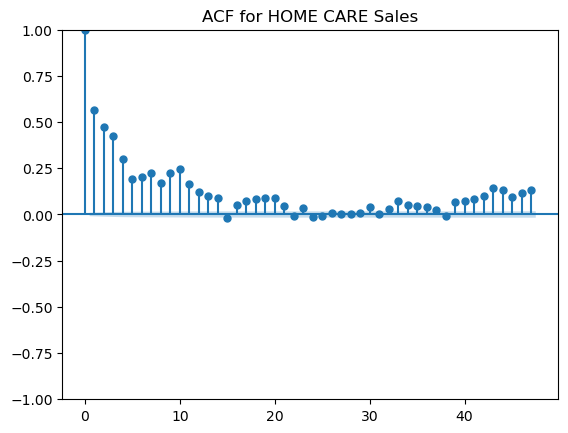

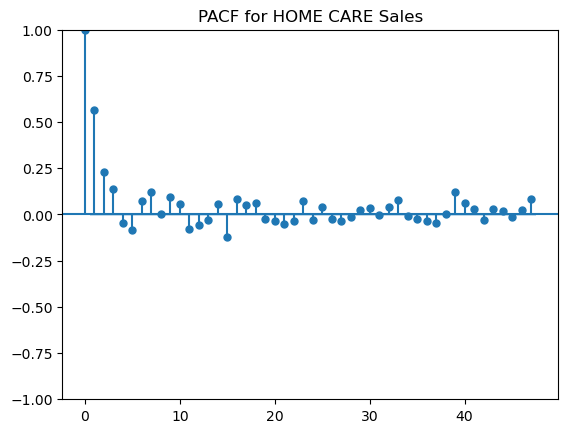

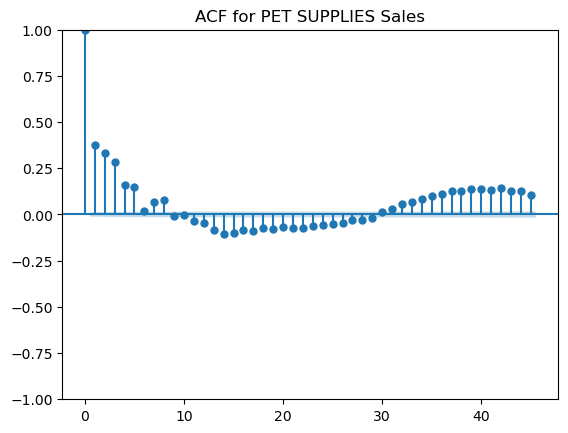

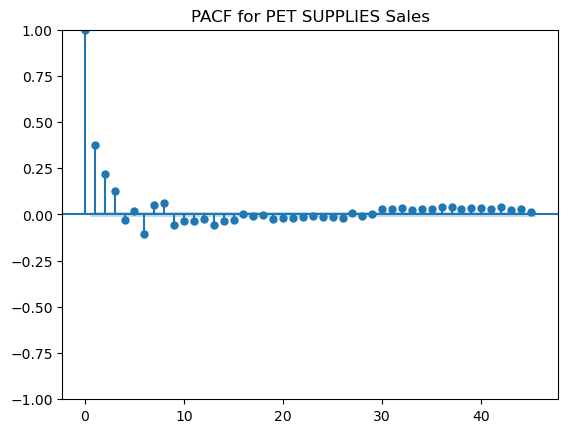

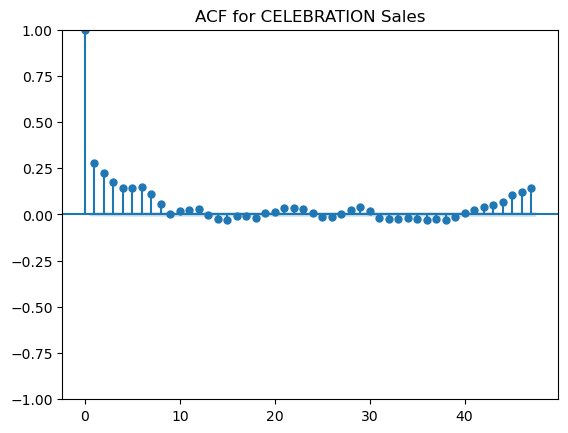

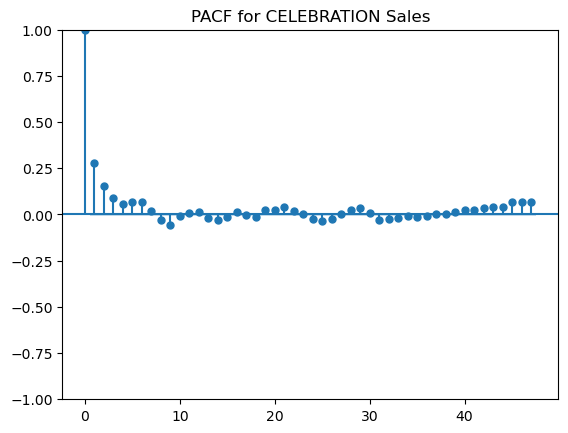

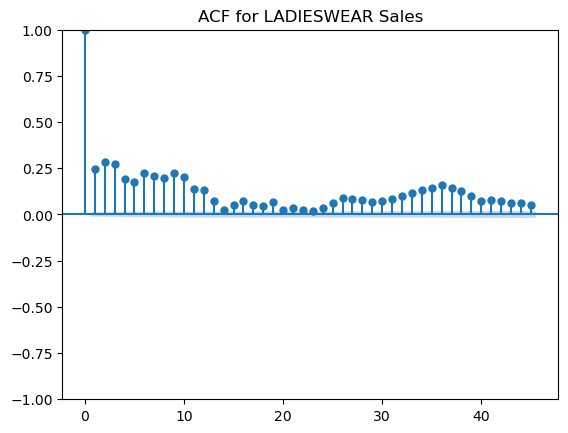

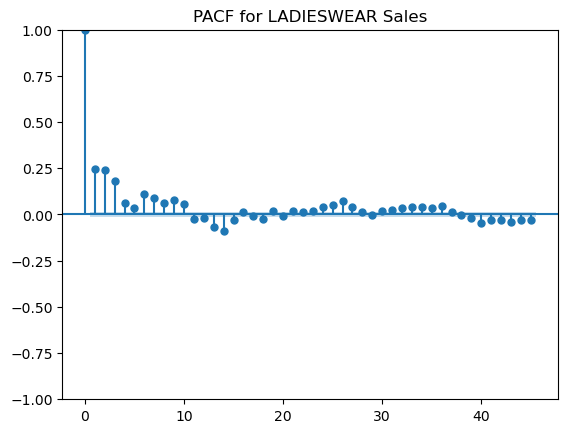

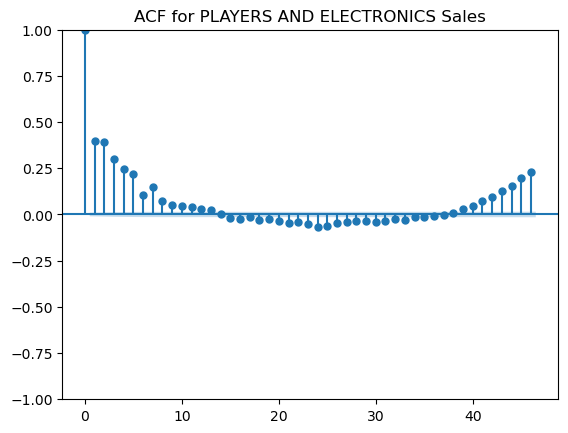

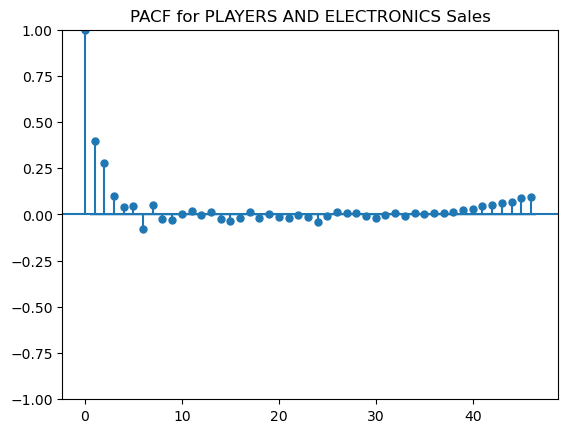

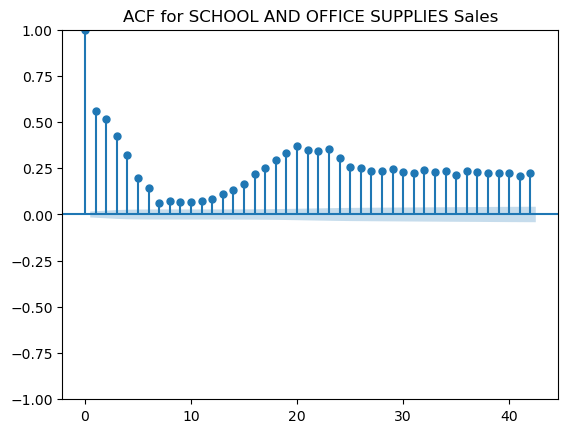

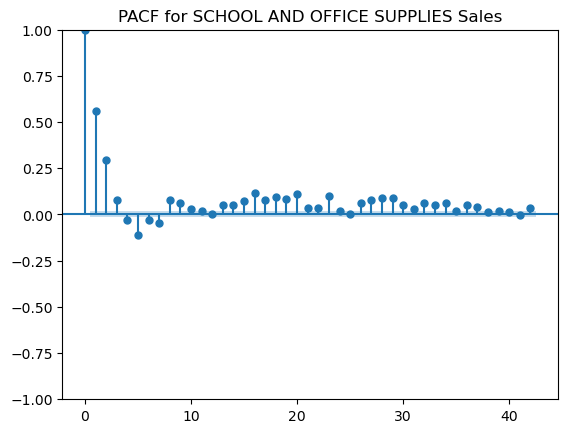

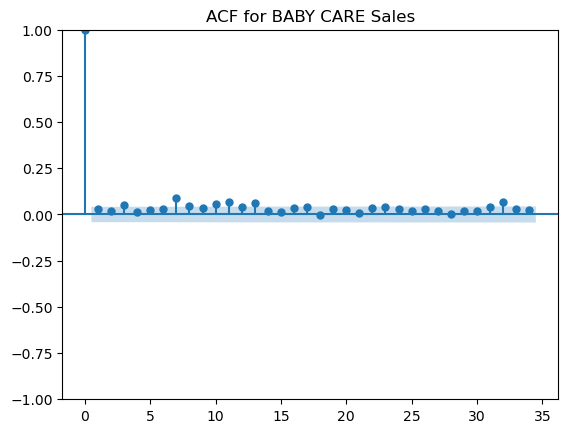

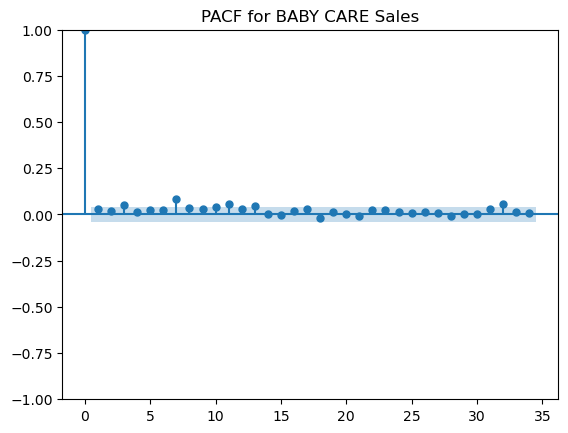

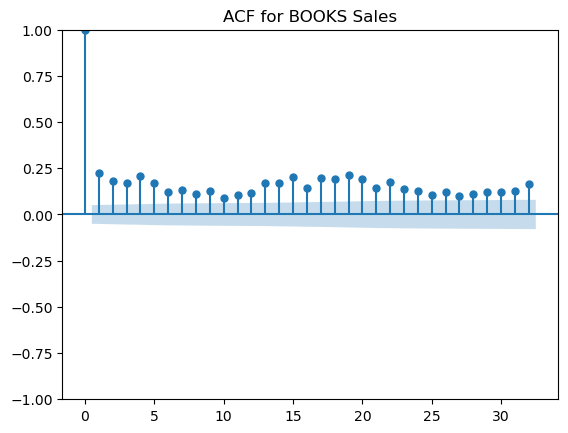

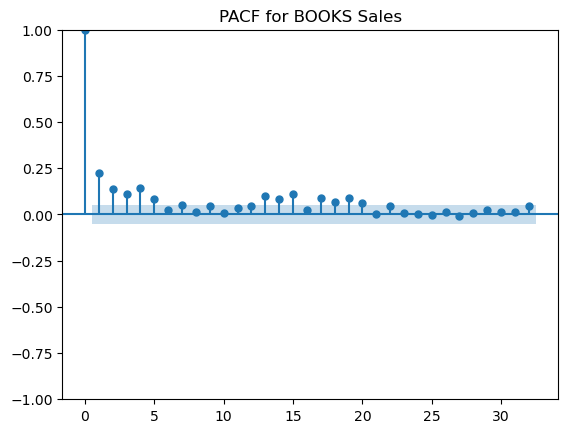

In [55]:
from statsmodels.graphics import tsaplots
families = train_df_copy['family'].unique()

for family in families:
    family_df = train_df_copy[train_df_copy['family'] == family]

    # ACF plot
    tsaplots.plot_acf(family_df['sales'])
    plt.title(f'ACF for {family} Sales')
    plt.show()

    # PACF plot
    tsaplots.plot_pacf(family_df['sales'], method='ywm')
    plt.title(f'PACF for {family} Sales')
    plt.show()

In [56]:
from statsmodels.tsa.stattools import adfuller, kpss

for family in families:
    family_df = train_df_copy[train_df_copy['family'] == family]

    # ADF Test
    adf_result = adfuller(family_df['sales'])
    print(f'ADF Test for {family} Sales: p-value = {adf_result[1]}')

    # KPSS Test
    kpss_result = kpss(family_df['sales'], regression='c')
    print(f'KPSS Test for {family} Sales: p-value = {kpss_result[1]}')

    print('---')

ADF Test for BEAUTY Sales: p-value = 9.544567330457072e-29
KPSS Test for BEAUTY Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for BEVERAGES Sales: p-value = 5.601296690609762e-19
KPSS Test for BEVERAGES Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for BREAD/BAKERY Sales: p-value = 8.916307165427354e-27
KPSS Test for BREAD/BAKERY Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for CLEANING Sales: p-value = 3.235425058839481e-24
KPSS Test for CLEANING Sales: p-value = 0.01282192747679334
---
ADF Test for DAIRY Sales: p-value = 1.7649207310006726e-26
KPSS Test for DAIRY Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for DELI Sales: p-value = 4.926245581086246e-25
KPSS Test for DELI Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for EGGS Sales: p-value = 7.655017717172619e-27
KPSS Test for EGGS Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for FROZEN FOODS Sales: p-value = 3.0913130865368155e-10
KPSS Test for FROZEN FOODS Sales: p-value = 0.09396883680604391
---
ADF Test for GROCERY I Sales: p-value = 3.8235082520097146e-22
KPSS Test for GROCERY I Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for GROCERY II Sales: p-value = 7.394219502505663e-26
KPSS Test for GROCERY II Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for HOME AND KITCHEN I Sales: p-value = 1.1915414429442416e-24
KPSS Test for HOME AND KITCHEN I Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for HOME AND KITCHEN II Sales: p-value = 1.0621843699200254e-22
KPSS Test for HOME AND KITCHEN II Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for LAWN AND GARDEN Sales: p-value = 2.3764395805004204e-24
KPSS Test for LAWN AND GARDEN Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for LINGERIE Sales: p-value = 0.0
KPSS Test for LINGERIE Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for LIQUOR,WINE,BEER Sales: p-value = 1.1793231357642013e-24
KPSS Test for LIQUOR,WINE,BEER Sales: p-value = 0.08018706679354412
---
ADF Test for MEATS Sales: p-value = 0.0
KPSS Test for MEATS Sales: p-value = 0.1
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for PERSONAL CARE Sales: p-value = 5.672798220699605e-25
KPSS Test for PERSONAL CARE Sales: p-value = 0.1
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for POULTRY Sales: p-value = 3.642639222507171e-30
KPSS Test for POULTRY Sales: p-value = 0.019808303691971264
---
ADF Test for PREPARED FOODS Sales: p-value = 7.413497940481342e-27
KPSS Test for PREPARED FOODS Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for PRODUCE Sales: p-value = 2.4469685772958667e-19
KPSS Test for PRODUCE Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for SEAFOOD Sales: p-value = 0.0
KPSS Test for SEAFOOD Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for AUTOMOTIVE Sales: p-value = 9.76463334248938e-30
KPSS Test for AUTOMOTIVE Sales: p-value = 0.09034902873344991
---
ADF Test for HARDWARE Sales: p-value = 2.3948611323708325e-30
KPSS Test for HARDWARE Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for HOME APPLIANCES Sales: p-value = 0.0
KPSS Test for HOME APPLIANCES Sales: p-value = 0.01542847031402004
---
ADF Test for MAGAZINES Sales: p-value = 1.6851447439298473e-22
KPSS Test for MAGAZINES Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for HOME CARE Sales: p-value = 8.459949162977452e-22
KPSS Test for HOME CARE Sales: p-value = 0.019369043909585028
---
ADF Test for PET SUPPLIES Sales: p-value = 2.1408197306868916e-30
KPSS Test for PET SUPPLIES Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for CELEBRATION Sales: p-value = 4.010550907069465e-24
KPSS Test for CELEBRATION Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for LADIESWEAR Sales: p-value = 0.0
KPSS Test for LADIESWEAR Sales: p-value = 0.1
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for PLAYERS AND ELECTRONICS Sales: p-value = 3.1192005718681385e-25
KPSS Test for PLAYERS AND ELECTRONICS Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for SCHOOL AND OFFICE SUPPLIES Sales: p-value = 0.017738695970483147
KPSS Test for SCHOOL AND OFFICE SUPPLIES Sales: p-value = 0.01
---
ADF Test for BABY CARE Sales: p-value = 2.807300171584377e-16
KPSS Test for BABY CARE Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')
/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


ADF Test for BOOKS Sales: p-value = 0.0016190046213182187
KPSS Test for BOOKS Sales: p-value = 0.01
---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1132714087.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(family_df['sales'], regression='c')


The low p-values indicate the data is non-stationary

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for BEAUTY Differenced Sales: p-value = 0.0


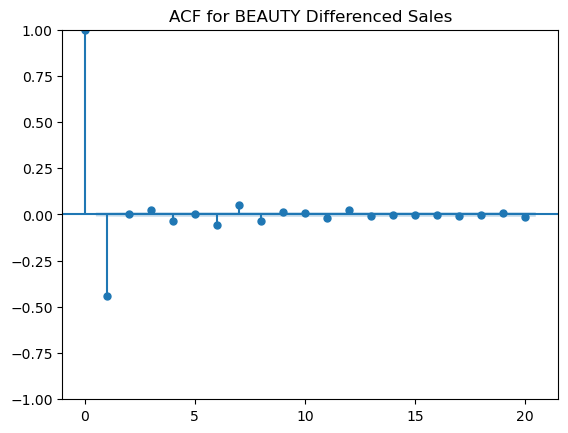

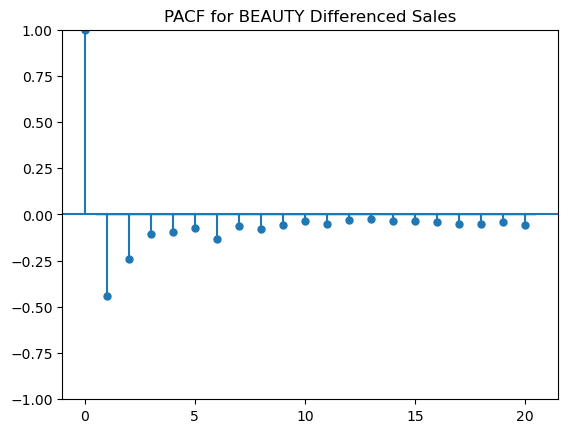

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for BEVERAGES Differenced Sales: p-value = 0.0


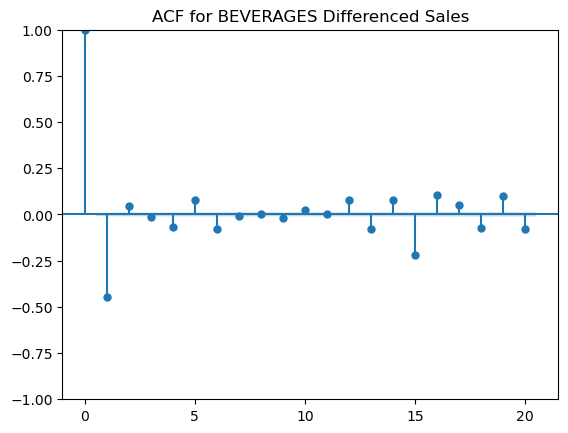

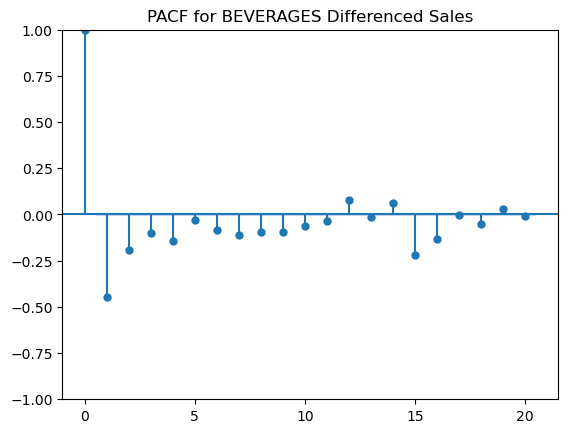

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for BREAD/BAKERY Differenced Sales: p-value = 0.0


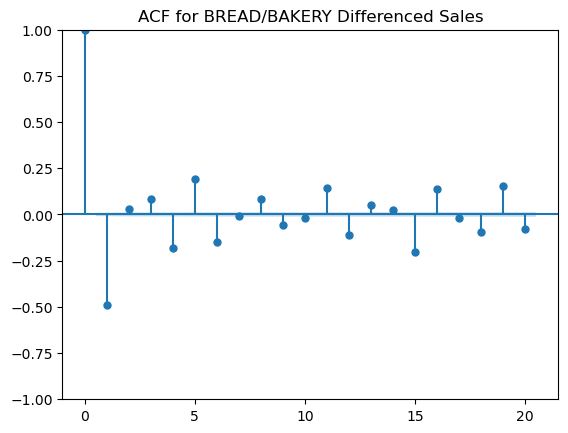

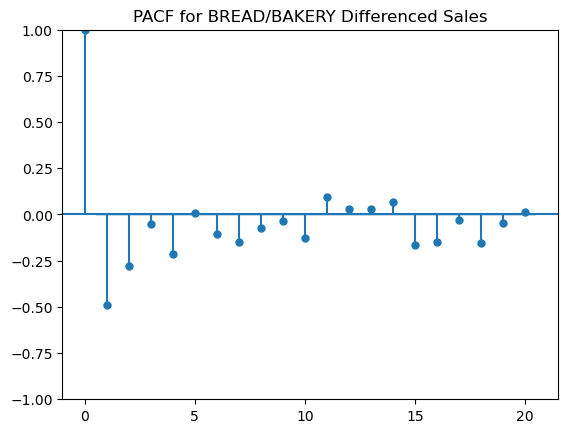

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for CLEANING Differenced Sales: p-value = 0.0


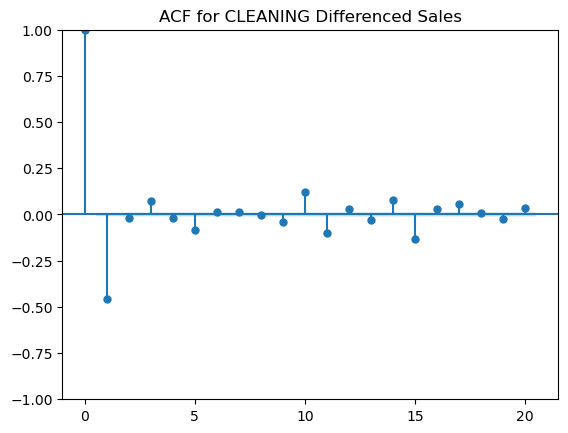

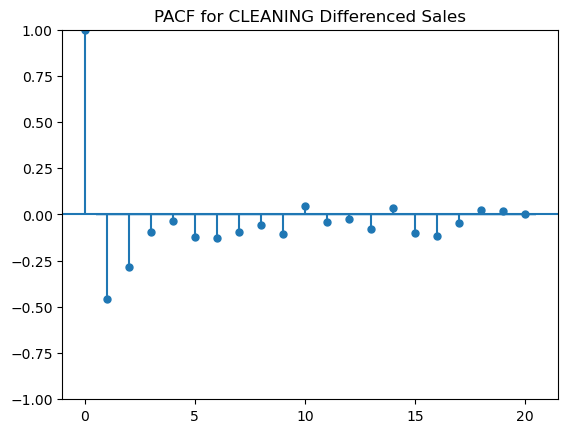

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for DAIRY Differenced Sales: p-value = 0.0


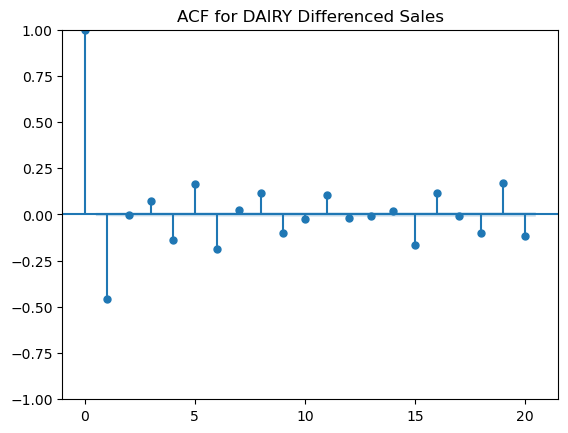

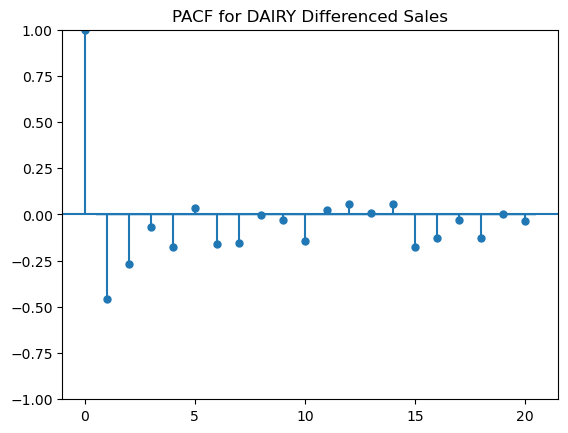

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for DELI Differenced Sales: p-value = 0.0


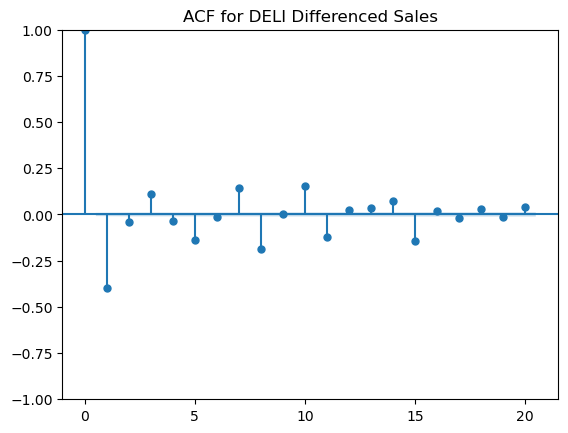

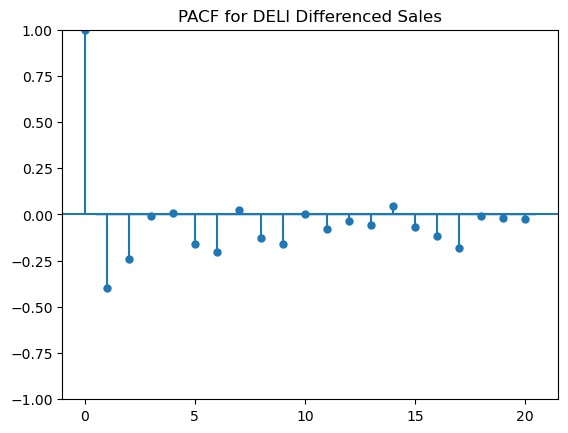

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for EGGS Differenced Sales: p-value = 0.0


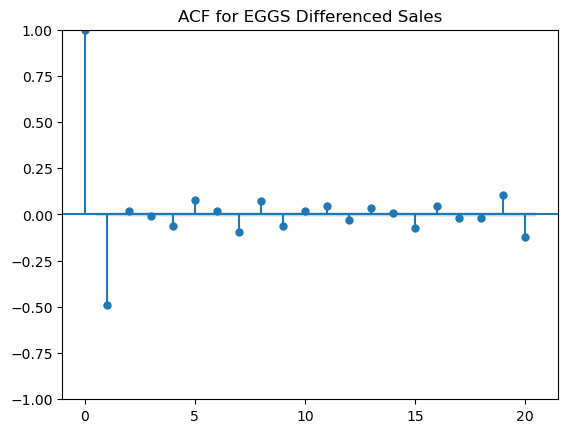

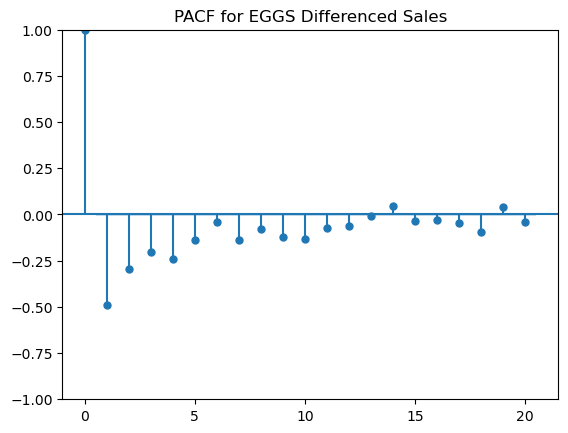

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for FROZEN FOODS Differenced Sales: p-value = 0.0


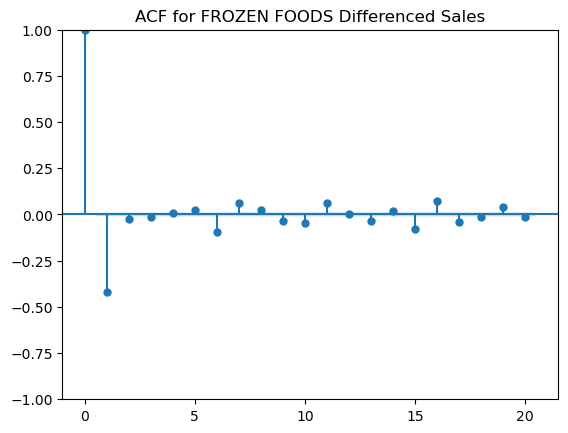

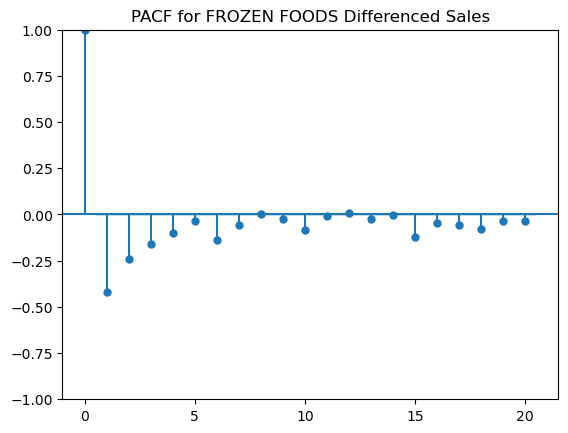

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for GROCERY I Differenced Sales: p-value = 0.0


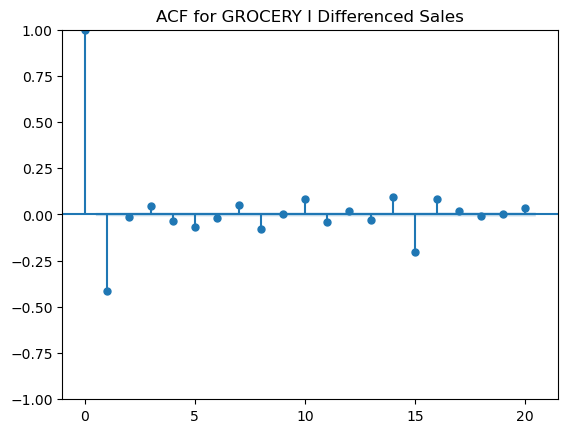

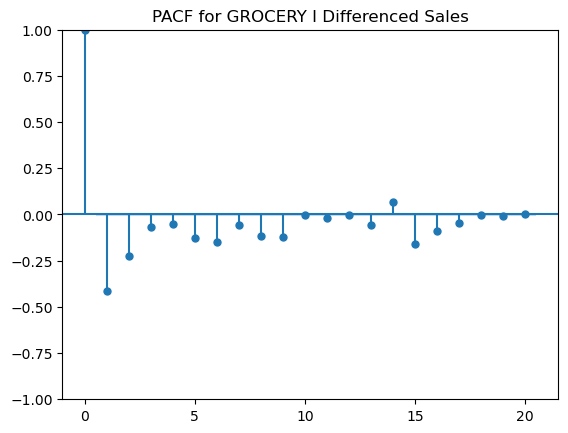

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for GROCERY II Differenced Sales: p-value = 0.0


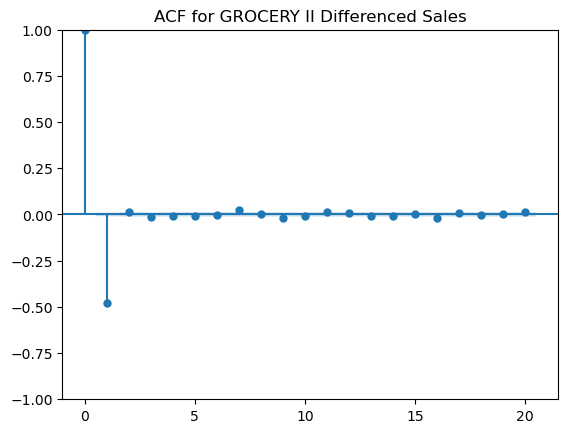

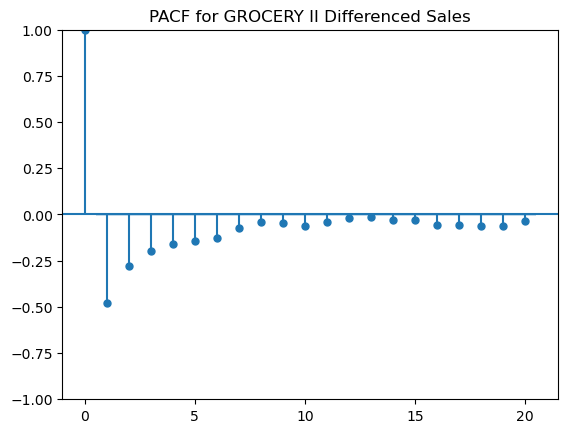

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for HOME AND KITCHEN I Differenced Sales: p-value = 0.0


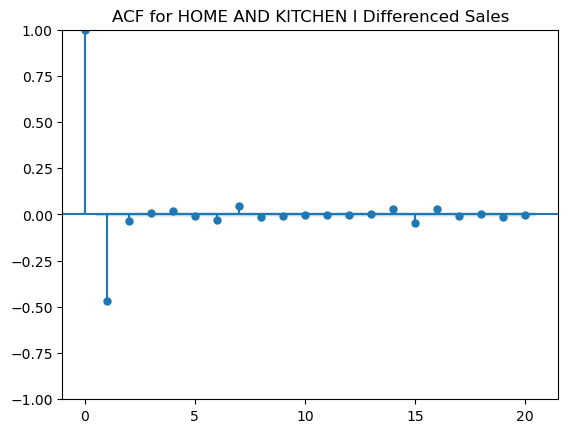

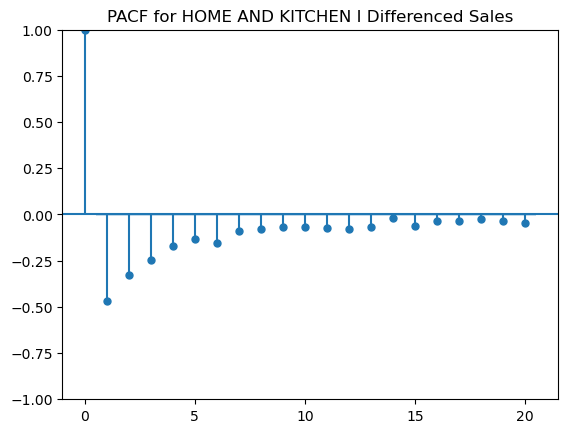

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for HOME AND KITCHEN II Differenced Sales: p-value = 0.0


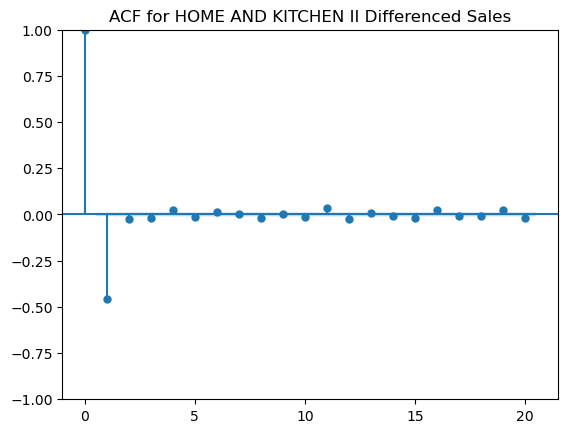

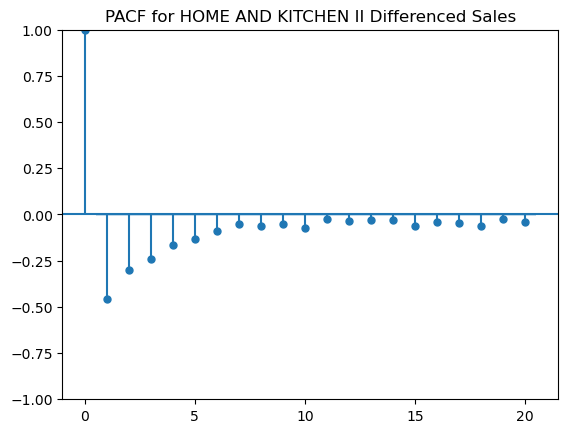

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for LAWN AND GARDEN Differenced Sales: p-value = 0.0


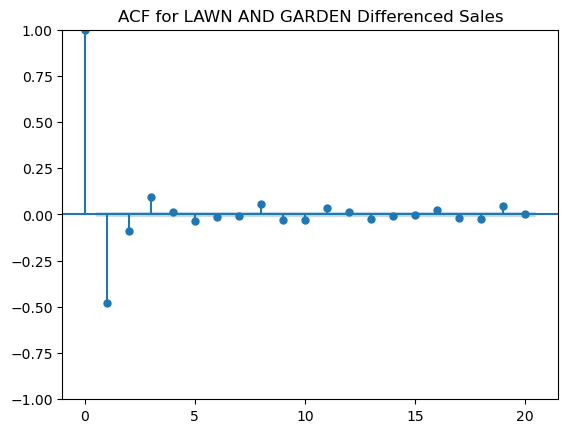

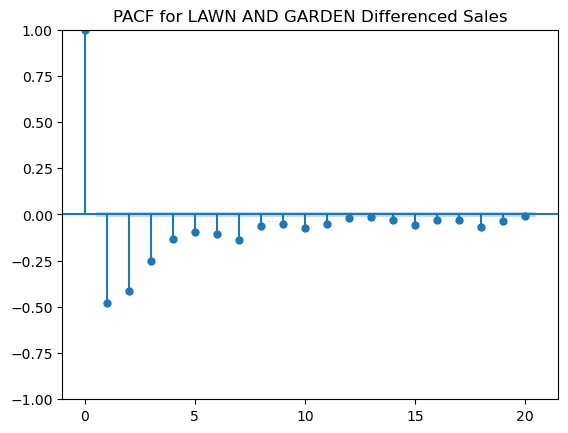

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for LINGERIE Differenced Sales: p-value = 0.0


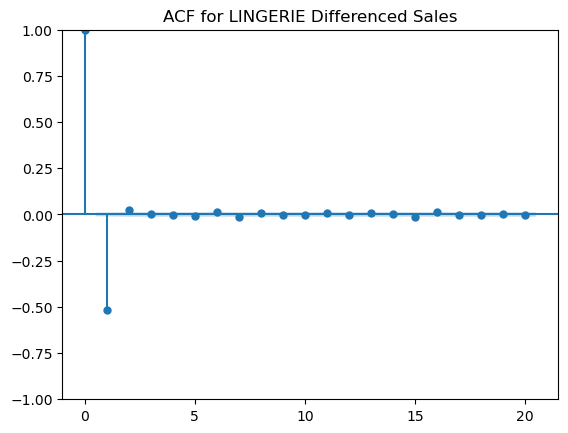

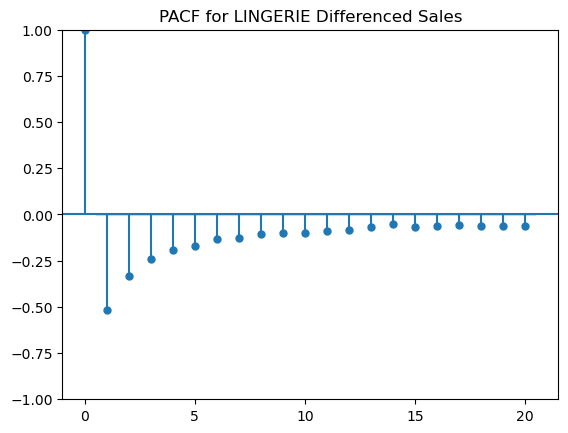

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for LIQUOR,WINE,BEER Differenced Sales: p-value = 0.0


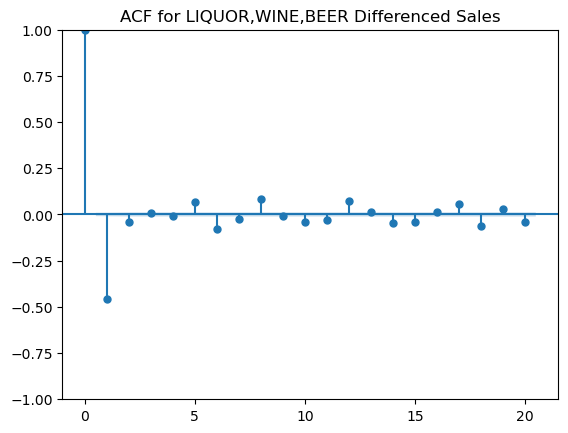

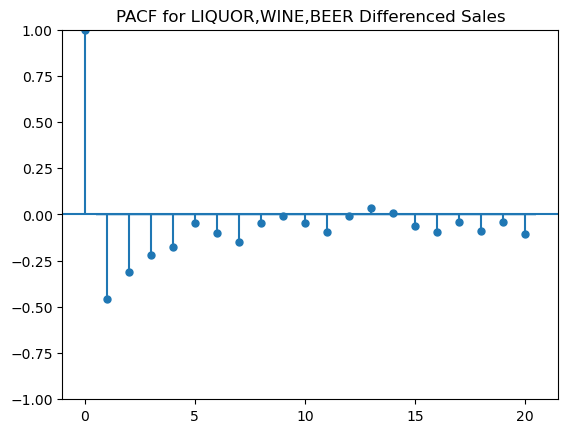

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for MEATS Differenced Sales: p-value = 0.0


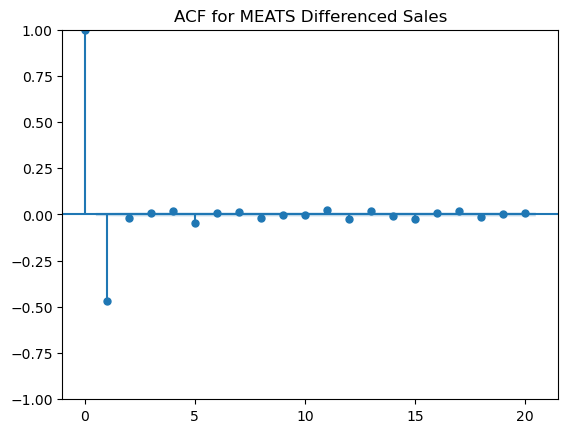

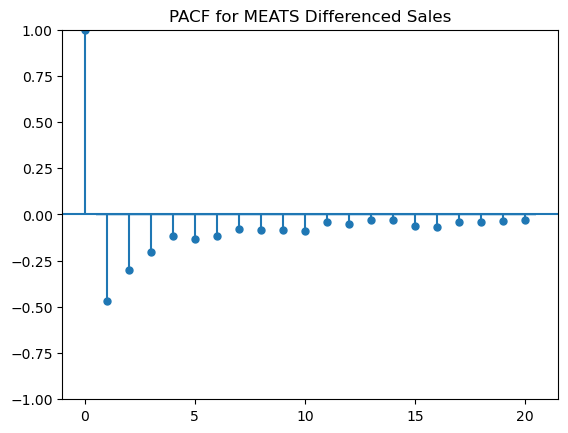

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for PERSONAL CARE Differenced Sales: p-value = 0.0


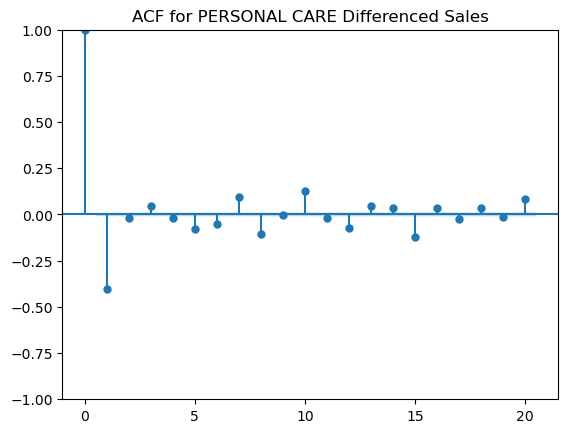

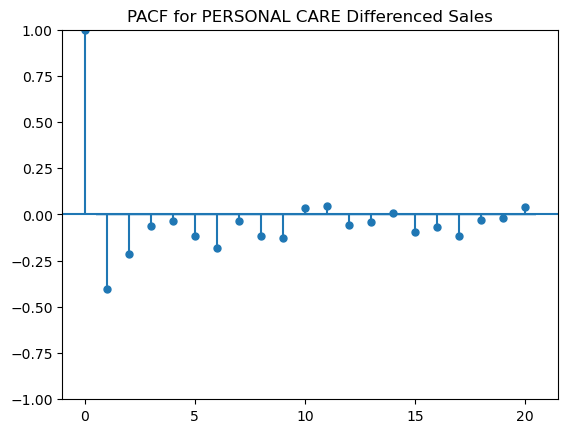

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for POULTRY Differenced Sales: p-value = 0.0


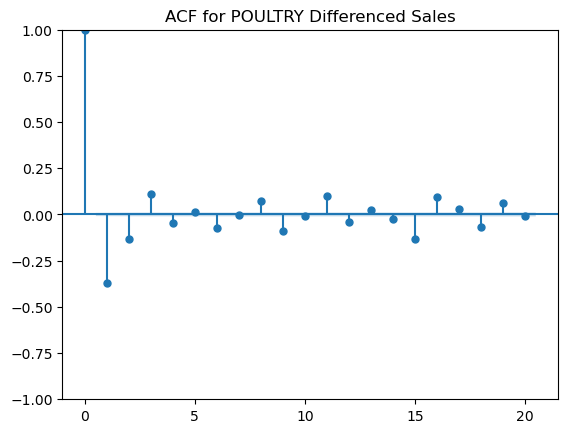

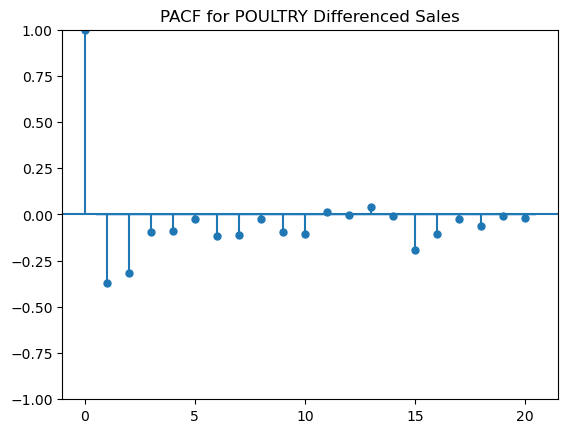

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for PREPARED FOODS Differenced Sales: p-value = 0.0


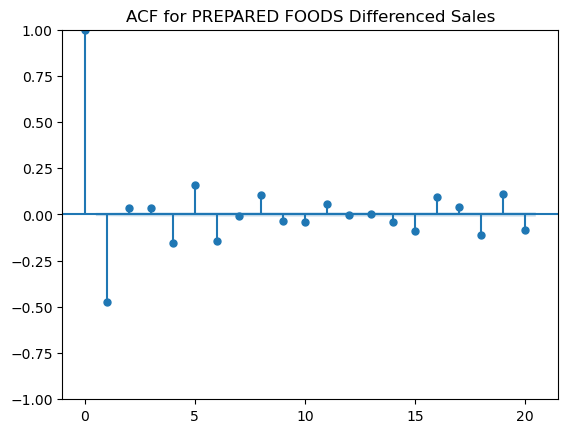

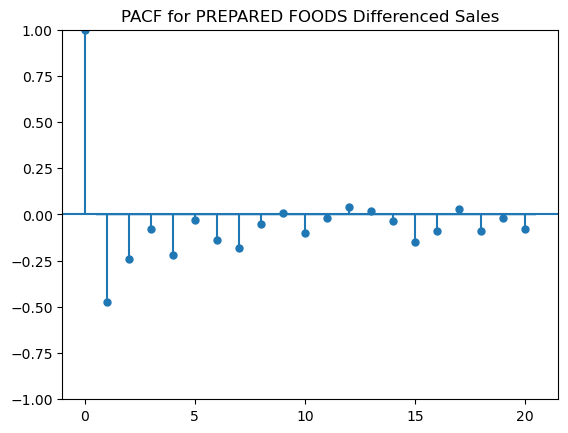

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for PRODUCE Differenced Sales: p-value = 0.0


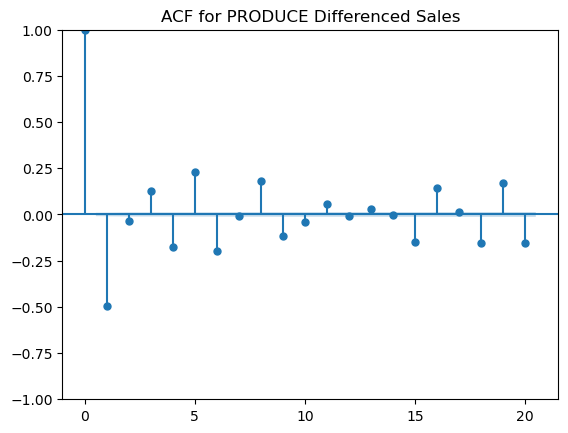

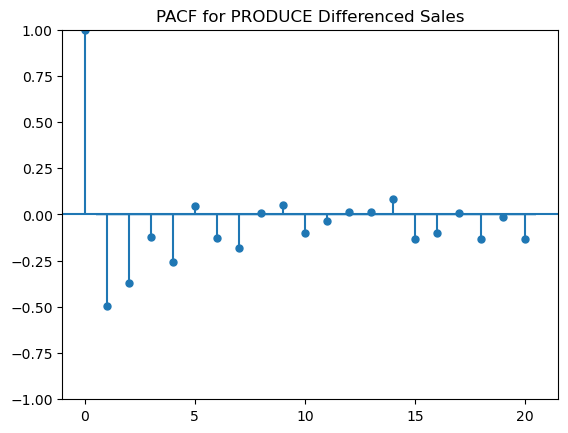

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for SEAFOOD Differenced Sales: p-value = 0.0


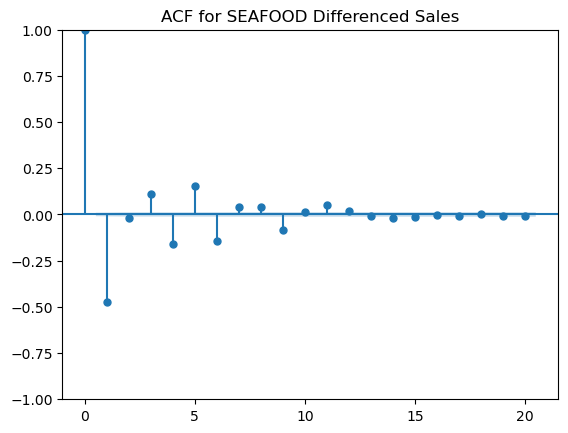

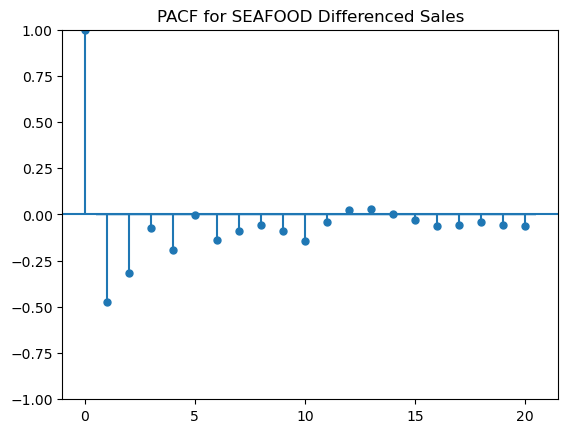

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for AUTOMOTIVE Differenced Sales: p-value = 0.0


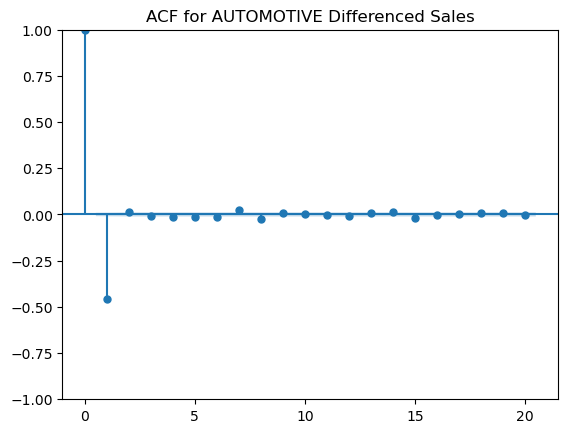

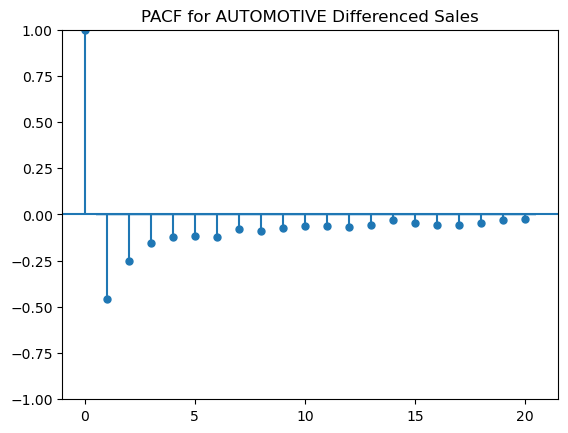

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for HARDWARE Differenced Sales: p-value = 0.0


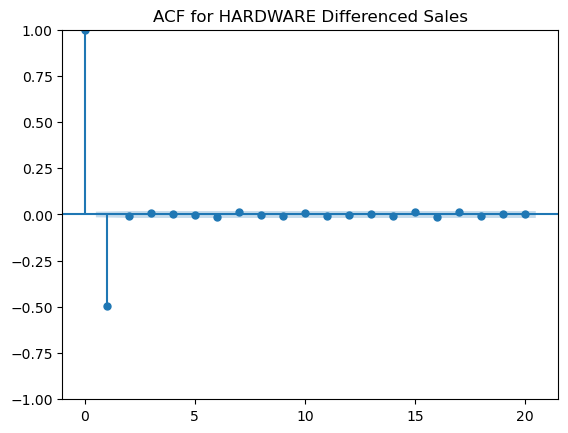

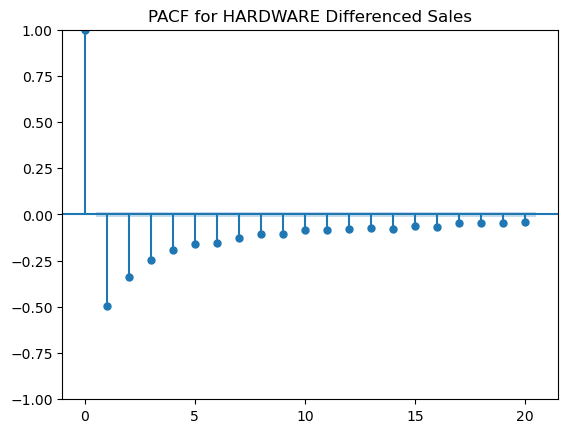

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for HOME APPLIANCES Differenced Sales: p-value = 0.0


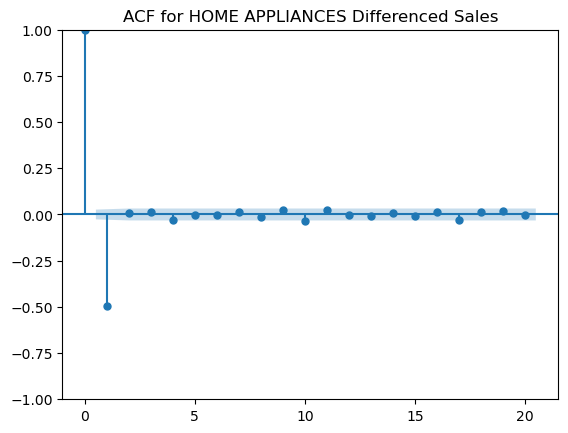

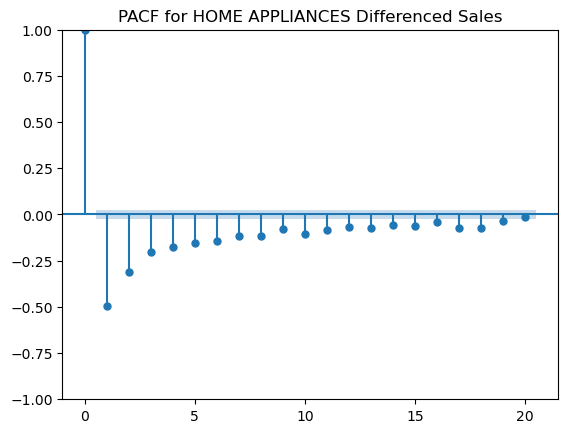

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for MAGAZINES Differenced Sales: p-value = 0.0


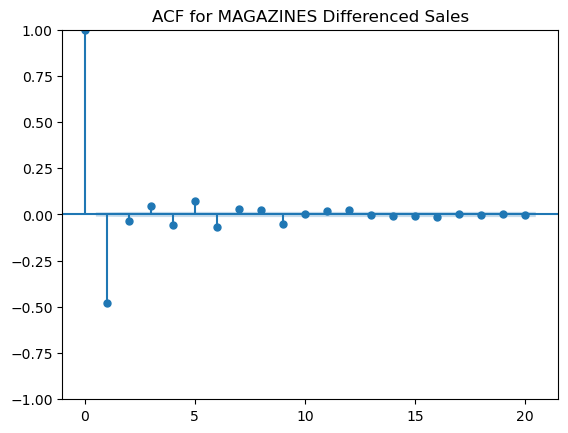

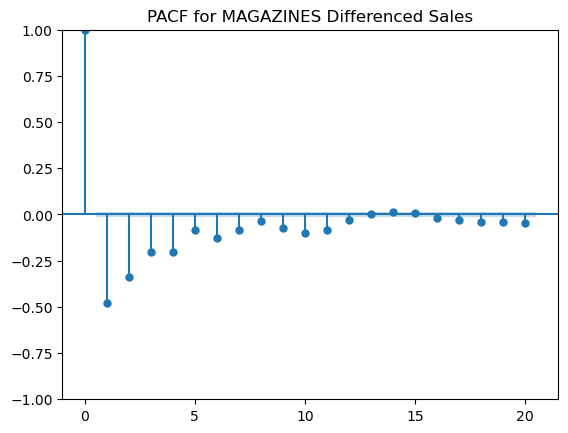

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for HOME CARE Differenced Sales: p-value = 0.0


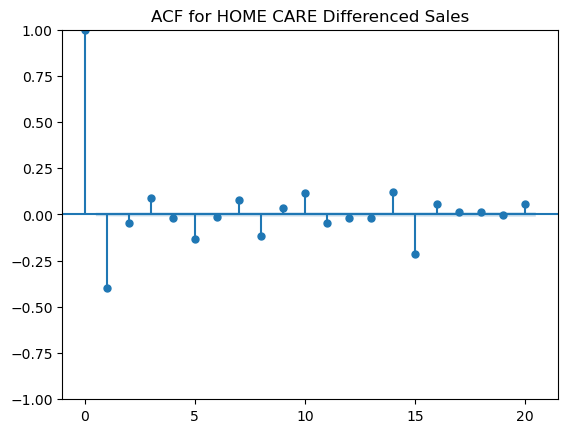

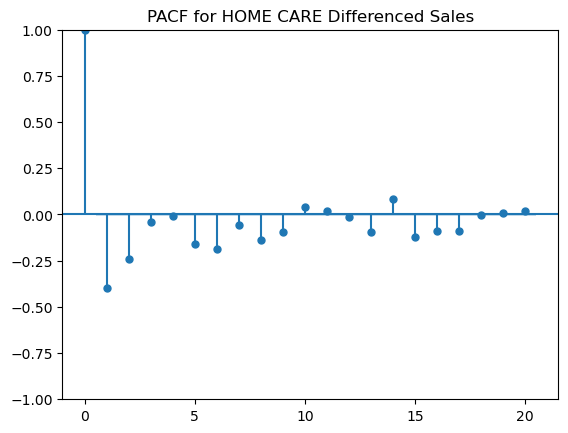

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for PET SUPPLIES Differenced Sales: p-value = 0.0


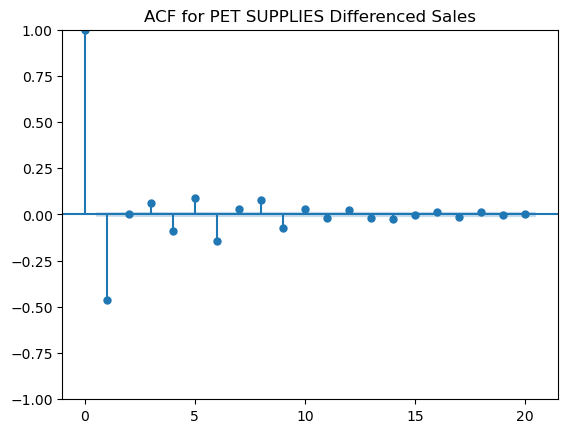

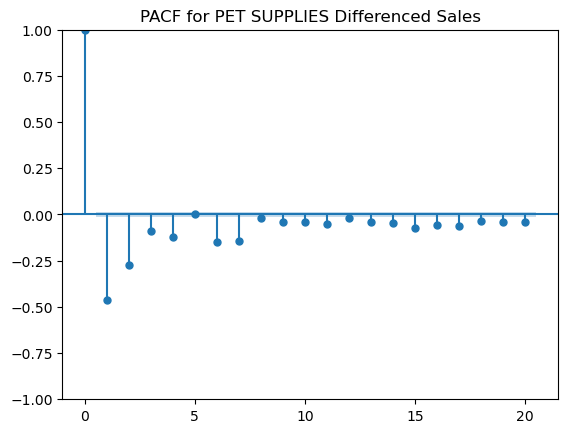

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for CELEBRATION Differenced Sales: p-value = 0.0


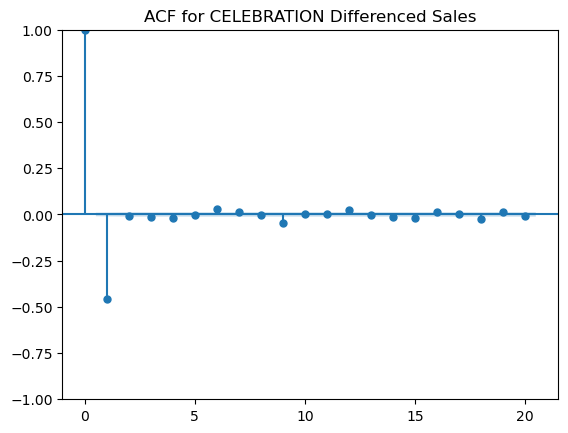

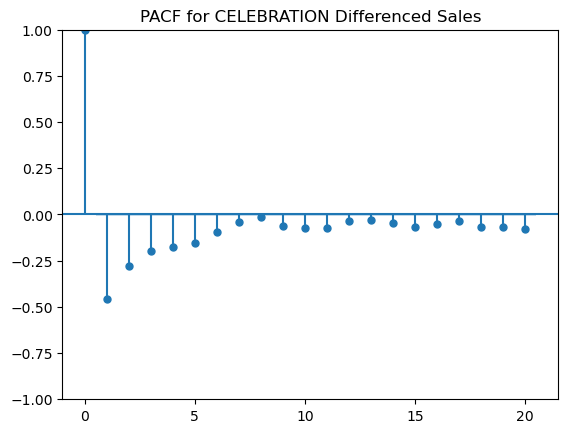

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for LADIESWEAR Differenced Sales: p-value = 0.0


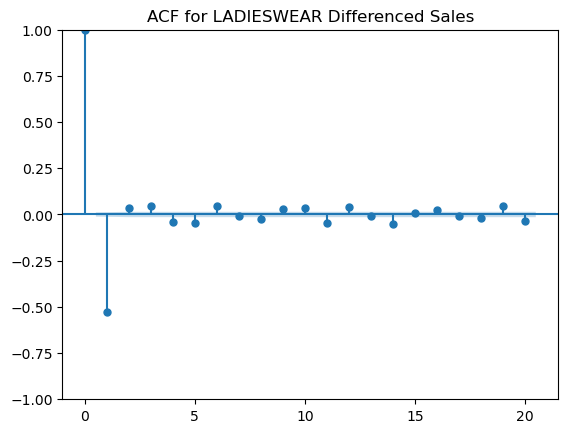

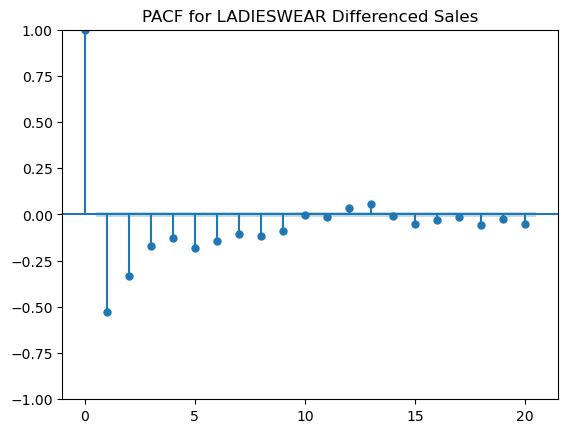

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for PLAYERS AND ELECTRONICS Differenced Sales: p-value = 0.0


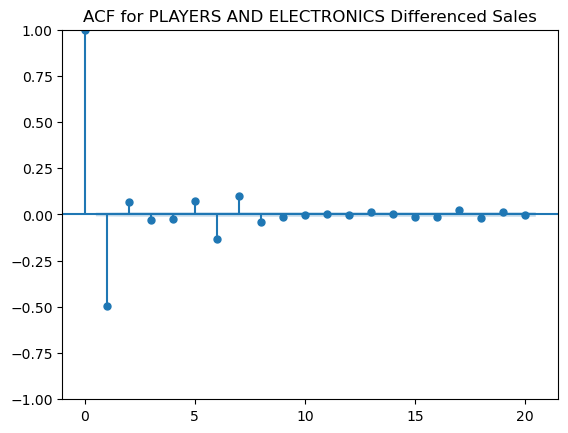

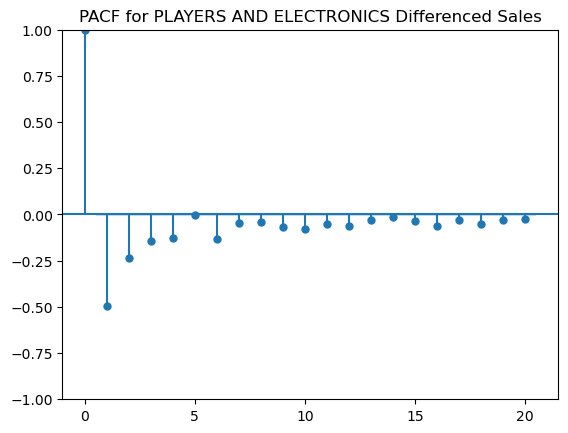

---


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


ADF Test for SCHOOL AND OFFICE SUPPLIES Differenced Sales: p-value = 0.0


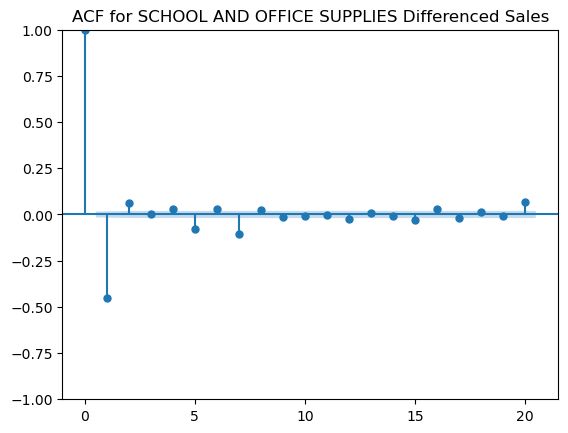

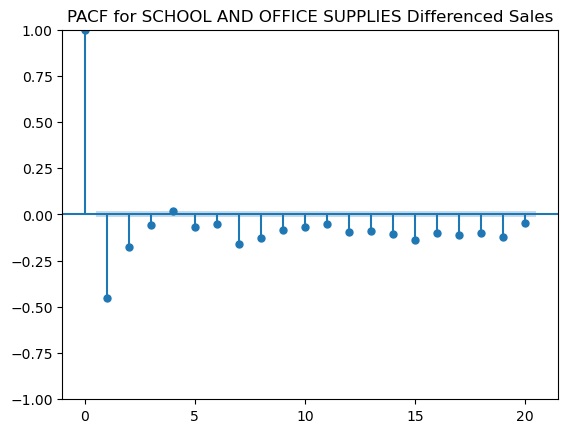

---
ADF Test for BABY CARE Differenced Sales: p-value = 4.598244624860371e-28


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


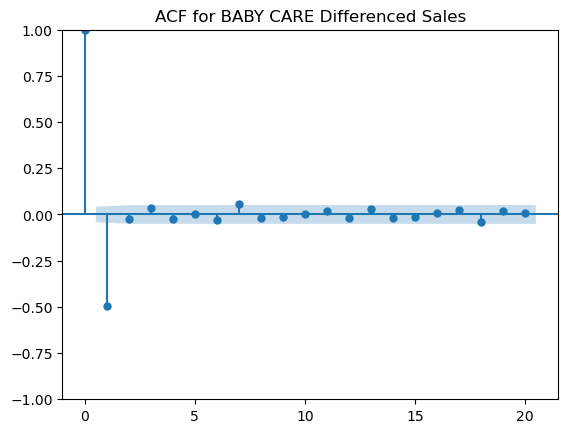

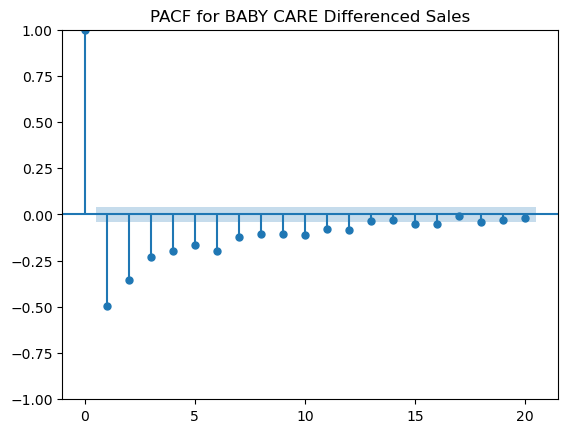

---
ADF Test for BOOKS Differenced Sales: p-value = 5.347418678240462e-29


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/1706782248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)


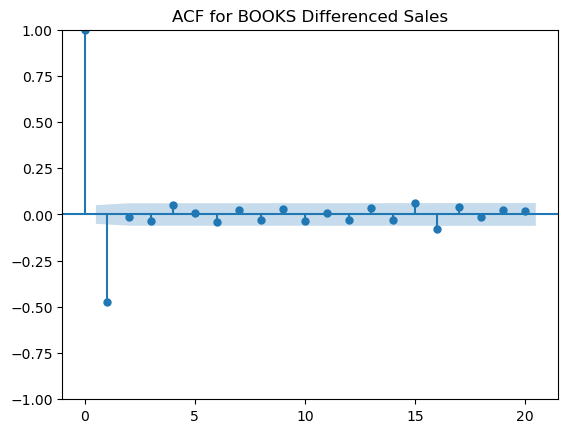

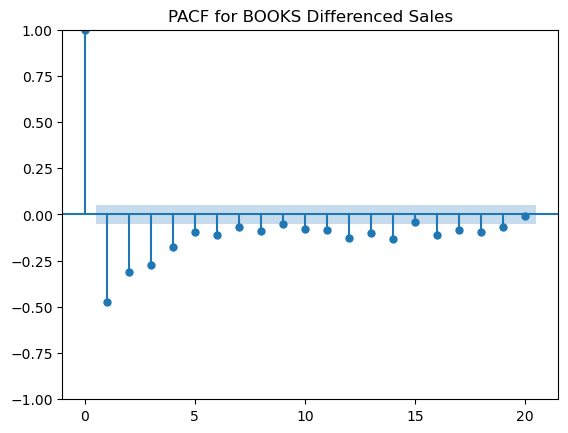

---


In [57]:
for family in families:
    family_df = train_df_copy[train_df_copy['family'] == family]

    # Differencing the sales data
    family_df['diff_sales'] = family_df['sales'].diff(1)
    family_df = family_df.dropna()

    # ADF Test on Differenced Data
    adf_result = adfuller(family_df['diff_sales'])
    print(f'ADF Test for {family} Differenced Sales: p-value = {adf_result[1]}')

    # ACF and PACF plots for Differenced Data
    tsaplots.plot_acf(family_df['diff_sales'], lags=20)
    plt.title(f'ACF for {family} Differenced Sales')
    plt.show()

    tsaplots.plot_pacf(family_df['diff_sales'], lags=20, method='ywm')
    plt.title(f'PACF for {family} Differenced Sales')
    plt.show()

    print('---')

In [58]:
from statsmodels.tsa.arima.model import ARIMA

for family in families:
    family_df = train_df_copy[train_df_copy['family'] == family]

    # Differencing the sales data
    family_df['diff_sales'] = family_df['sales'].diff(1)
    family_df = family_df.dropna()

    # Build ARIMA model (adjust order as needed based on ACF/PACF)
    arima_model = ARIMA(family_df['diff_sales'], order=(2, 1, 1)).fit()

    # Print model summary
    print(f'ARIMA Model Summary for {family}:')
    print(arima_model.summary())
    print('---')

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for BEAUTY:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                34261
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -104893.468
Date:                Fri, 27 Sep 2024   AIC                         209794.936
Time:                        10:10:41   BIC                         209828.703
Sample:                             0   HQIC                        209805.702
                              - 34261                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5508      0.002   -244.539      0.000      -0.555      -0.546
ar.L2         -0.2411      0.003    -87.378      0.000      -0.247      -0.236
ma.L1         -1.000

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for BEVERAGES:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                50552
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -459585.948
Date:                Fri, 27 Sep 2024   AIC                         919179.897
Time:                        10:11:05   BIC                         919215.219
Sample:                             0   HQIC                        919190.956
                              - 50552                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5296      0.003   -186.502      0.000      -0.535      -0.524
ar.L2         -0.1918      0.003    -56.735      0.000      -0.198      -0.185
ma.L1         -1.

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for BREAD/BAKERY:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                50553
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -369436.281
Date:                Fri, 27 Sep 2024   AIC                         738880.561
Time:                        10:11:22   BIC                         738915.884
Sample:                             0   HQIC                        738891.620
                              - 50553                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6281      0.004   -159.589      0.000      -0.636      -0.620
ar.L2         -0.2806      0.004    -64.956      0.000      -0.289      -0.272
ma.L1         

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for CLEANING:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                50552
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -397802.184
Date:                Fri, 27 Sep 2024   AIC                         795612.368
Time:                        10:11:34   BIC                         795647.691
Sample:                             0   HQIC                        795623.427
                              - 50552                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5861      0.002   -263.304      0.000      -0.591      -0.582
ar.L2         -0.2853      0.003   -113.314      0.000      -0.290      -0.280
ma.L1         -1.0

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for DAIRY:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                50552
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -398783.655
Date:                Fri, 27 Sep 2024   AIC                         797575.310
Time:                        10:11:48   BIC                         797610.633
Sample:                             0   HQIC                        797586.369
                              - 50552                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5782      0.003   -174.954      0.000      -0.585      -0.572
ar.L2         -0.2686      0.004    -64.371      0.000      -0.277      -0.260
ma.L1         -1.0000

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for DELI:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                50552
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -335453.855
Date:                Fri, 27 Sep 2024   AIC                         670915.711
Time:                        10:11:59   BIC                         670951.034
Sample:                             0   HQIC                        670926.770
                              - 50552                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4966      0.003   -154.739      0.000      -0.503      -0.490
ar.L2         -0.2411      0.003    -72.994      0.000      -0.248      -0.235
ma.L1         -1.0000 

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for EGGS:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                50552
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -333221.255
Date:                Fri, 27 Sep 2024   AIC                         666450.510
Time:                        10:12:11   BIC                         666485.833
Sample:                             0   HQIC                        666461.569
                              - 50552                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6369      0.002   -260.062      0.000      -0.642      -0.632
ar.L2         -0.2932      0.002   -120.642      0.000      -0.298      -0.288
ma.L1         -1.0000 

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for FROZEN FOODS:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                50548
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -352673.804
Date:                Fri, 27 Sep 2024   AIC                         705355.608
Time:                        10:12:22   BIC                         705390.931
Sample:                             0   HQIC                        705366.667
                              - 50548                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5172      0.001  -1011.766      0.000      -0.518      -0.516
ar.L2         -0.2387      0.001   -408.238      0.000      -0.240      -0.238
ma.L1         

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for GROCERY I:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                50551
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -469350.230
Date:                Fri, 27 Sep 2024   AIC                         938708.460
Time:                        10:12:44   BIC                         938743.783
Sample:                             0   HQIC                        938719.520
                              - 50551                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5051      0.001   -712.276      0.000      -0.506      -0.504
ar.L2         -0.2220      0.001   -248.605      0.000      -0.224      -0.220
ma.L1         -1.

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for GROCERY II:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                45970
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -228190.977
Date:                Fri, 27 Sep 2024   AIC                         456389.954
Time:                        10:13:02   BIC                         456424.897
Sample:                             0   HQIC                        456400.942
                              - 45970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6121      0.000  -2251.384      0.000      -0.613      -0.612
ar.L2         -0.2799      0.000   -903.118      0.000      -0.281      -0.279
ma.L1         -1

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for HOME AND KITCHEN I:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                50041
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -258806.865
Date:                Fri, 27 Sep 2024   AIC                         517621.729
Time:                        10:13:26   BIC                         517657.012
Sample:                             0   HQIC                        517632.781
                              - 50041                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6233      0.001   -934.278      0.000      -0.625      -0.622
ar.L2         -0.3290      0.001   -462.811      0.000      -0.330      -0.328
ma.L1   

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for HOME AND KITCHEN II:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                49956
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -254958.882
Date:                Fri, 27 Sep 2024   AIC                         509925.763
Time:                        10:13:51   BIC                         509961.039
Sample:                             0   HQIC                        509936.814
                              - 49956                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5971      0.001   -618.494      0.000      -0.599      -0.595
ar.L2         -0.2999      0.001   -274.860      0.000      -0.302      -0.298
ma.L1  

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for LAWN AND GARDEN:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                27912
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -116865.262
Date:                Fri, 27 Sep 2024   AIC                         233738.525
Time:                        10:14:03   BIC                         233771.472
Sample:                             0   HQIC                        233749.132
                              - 27912                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6796      0.001   -510.782      0.000      -0.682      -0.677
ar.L2         -0.4137      0.001   -340.373      0.000      -0.416      -0.411
ma.L1      

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for LINGERIE:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                40084
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -154542.493
Date:                Fri, 27 Sep 2024   AIC                         309092.987
Time:                        10:14:21   BIC                         309127.381
Sample:                             0   HQIC                        309103.872
                              - 40084                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6926      0.000  -2515.077      0.000      -0.693      -0.692
ar.L2         -0.3354      0.000  -1218.096      0.000      -0.336      -0.335
ma.L1         -1.0

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for LIQUOR,WINE,BEER:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                46480
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -289701.964
Date:                Fri, 27 Sep 2024   AIC                         579411.928
Time:                        10:14:31   BIC                         579446.915
Sample:                             0   HQIC                        579422.925
                              - 46480                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5977      0.001   -570.771      0.000      -0.600      -0.596
ar.L2         -0.3119      0.001   -261.119      0.000      -0.314      -0.310
ma.L1     

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for MEATS:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                50551
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -391359.084
Date:                Fri, 27 Sep 2024   AIC                         782726.168
Time:                        10:14:43   BIC                         782761.491
Sample:                             0   HQIC                        782737.227
                              - 50551                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6063   8.73e-05  -6947.038      0.000      -0.606      -0.606
ar.L2         -0.3000      0.000  -2969.783      0.000      -0.300      -0.300
ma.L1         -1.0000

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for PERSONAL CARE:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                50547
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -339155.373
Date:                Fri, 27 Sep 2024   AIC                         678318.745
Time:                        10:15:05   BIC                         678354.068
Sample:                             0   HQIC                        678329.804
                              - 50547                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4884      0.001   -490.486      0.000      -0.490      -0.486
ar.L2         -0.2148      0.001   -181.541      0.000      -0.217      -0.213
ma.L1        

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for POULTRY:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                50549
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -373486.053
Date:                Fri, 27 Sep 2024   AIC                         746980.105
Time:                        10:15:20   BIC                         747015.428
Sample:                             0   HQIC                        746991.164
                              - 50549                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4888      0.002   -251.964      0.000      -0.493      -0.485
ar.L2         -0.3158      0.002   -142.499      0.000      -0.320      -0.311
ma.L1         -1.00

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for PREPARED FOODS:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                50533
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -304169.300
Date:                Fri, 27 Sep 2024   AIC                         608346.601
Time:                        10:15:31   BIC                         608381.922
Sample:                             0   HQIC                        608357.660
                              - 50533                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5869      0.004   -153.209      0.000      -0.594      -0.579
ar.L2         -0.2417      0.004    -62.254      0.000      -0.249      -0.234
ma.L1       

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for PRODUCE:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                46120
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -423628.401
Date:                Fri, 27 Sep 2024   AIC                         847264.801
Time:                        10:15:53   BIC                         847299.757
Sample:                             0   HQIC                        847275.792
                              - 46120                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6782      0.004   -185.265      0.000      -0.685      -0.671
ar.L2         -0.3692      0.004   -100.632      0.000      -0.376      -0.362
ma.L1         -1.00

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for SEAFOOD:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                42493
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -210721.383
Date:                Fri, 27 Sep 2024   AIC                         421450.766
Time:                        10:16:10   BIC                         421485.394
Sample:                             0   HQIC                        421461.696
                              - 42493                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6264      0.004   -163.618      0.000      -0.634      -0.619
ar.L2         -0.3169      0.004    -77.633      0.000      -0.325      -0.309
ma.L1         -1.00

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for AUTOMOTIVE:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                44988
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -145053.571
Date:                Fri, 27 Sep 2024   AIC                         290115.143
Time:                        10:16:30   BIC                         290149.999
Sample:                             0   HQIC                        290126.115
                              - 44988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5753      0.001   -398.633      0.000      -0.578      -0.572
ar.L2         -0.2507      0.002   -145.595      0.000      -0.254      -0.247
ma.L1         -1

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for HARDWARE:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                16072
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -34438.863
Date:                Fri, 27 Sep 2024   AIC                          68885.725
Time:                        10:16:37   BIC                          68916.464
Sample:                             0   HQIC                         68895.890
                              - 16072                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6622      0.004   -164.318      0.000      -0.670      -0.654
ar.L2         -0.3375      0.004    -93.502      0.000      -0.345      -0.330
ma.L1         -1.0

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for HOME APPLIANCES:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                 5480
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -9447.938
Date:                Fri, 27 Sep 2024   AIC                          18903.875
Time:                        10:16:40   BIC                          18930.310
Sample:                             0   HQIC                         18913.097
                               - 5480                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6498      0.010    -64.440      0.000      -0.670      -0.630
ar.L2         -0.3115      0.010    -30.567      0.000      -0.331      -0.292
ma.L1      

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for MAGAZINES:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                28583
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -100953.195
Date:                Fri, 27 Sep 2024   AIC                         201914.390
Time:                        10:16:56   BIC                         201947.432
Sample:                             0   HQIC                        201925.016
                              - 28583                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6386      0.004   -163.589      0.000      -0.646      -0.631
ar.L2         -0.3377      0.004    -82.054      0.000      -0.346      -0.330
ma.L1         -1.

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for HOME CARE:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                44601
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -290256.156
Date:                Fri, 27 Sep 2024   AIC                         580520.311
Time:                        10:17:05   BIC                         580555.133
Sample:                             0   HQIC                        580531.277
                              - 44601                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4923      0.003   -165.455      0.000      -0.498      -0.486
ar.L2         -0.2436      0.003    -74.638      0.000      -0.250      -0.237
ma.L1         -1.

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for PET SUPPLIES:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                29216
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -107012.442
Date:                Fri, 27 Sep 2024   AIC                         214032.884
Time:                        10:17:18   BIC                         214066.014
Sample:                             0   HQIC                        214043.527
                              - 29216                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5916      0.005   -118.925      0.000      -0.601      -0.582
ar.L2         -0.2738      0.005    -53.008      0.000      -0.284      -0.264
ma.L1         

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for CELEBRATION:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                40800
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -170596.845
Date:                Fri, 27 Sep 2024   AIC                         341201.689
Time:                        10:17:37   BIC                         341236.155
Sample:                             0   HQIC                        341212.588
                              - 40800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5870      0.002   -367.440      0.000      -0.590      -0.584
ar.L2         -0.2775      0.002   -156.287      0.000      -0.281      -0.274
ma.L1         -

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for LADIESWEAR:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                28409
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -119207.840
Date:                Fri, 27 Sep 2024   AIC                         238423.681
Time:                        10:17:49   BIC                         238456.699
Sample:                             0   HQIC                        238434.303
                              - 28409                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7026      0.004   -182.958      0.000      -0.710      -0.695
ar.L2         -0.3349      0.004    -77.191      0.000      -0.343      -0.326
ma.L1         -1

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for PLAYERS AND ELECTRONICS:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                39152
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -149669.563
Date:                Fri, 27 Sep 2024   AIC                         299347.126
Time:                        10:18:05   BIC                         299381.427
Sample:                             0   HQIC                        299357.994
                              - 39152                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6108      0.002   -277.789      0.000      -0.615      -0.607
ar.L2         -0.2339      0.003    -85.828      0.000      -0.239      -0.229
ma.

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for SCHOOL AND OFFICE SUPPLIES:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                14616
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -75225.652
Date:                Fri, 27 Sep 2024   AIC                         150459.304
Time:                        10:18:11   BIC                         150489.663
Sample:                             0   HQIC                        150469.390
                              - 14616                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5299      0.002   -343.172      0.000      -0.533      -0.527
ar.L2         -0.1784      0.002    -99.591      0.000      -0.182      -0.175


/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for BABY CARE:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                 2219
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -5760.087
Date:                Fri, 27 Sep 2024   AIC                          11528.173
Time:                        10:18:13   BIC                          11550.990
Sample:                             0   HQIC                         11536.507
                               - 2219                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6681      0.002   -318.906      0.000      -0.672      -0.664
ar.L2         -0.3541      0.002   -173.779      0.000      -0.358      -0.350
ma.L1         -1.

/var/folders/9z/xd6qhps576s3xjk8023gqphw0000gn/T/ipykernel_6485/3273358814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_df['diff_sales'] = family_df['sales'].diff(1)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and

ARIMA Model Summary for BOOKS:
                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                 1508
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3515.323
Date:                Fri, 27 Sep 2024   AIC                           7038.646
Time:                        10:18:13   BIC                           7059.917
Sample:                             0   HQIC                          7046.568
                               - 1508                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6250      0.006    -96.387      0.000      -0.638      -0.612
ar.L2         -0.3141      0.007    -46.603      0.000      -0.327      -0.301
ma.L1         -0.9999

In [62]:
for family in families:
    family_df = train_df_copy[train_df_copy['family'] == family].copy()

    # Differencing the sales data
    family_df.loc[:, 'diff_sales'] = family_df['sales'].diff(1)
    family_df = family_df.dropna()

    # Build ARIMA model (adjust order as needed based on ACF/PACF)
    arima_model = ARIMA(family_df['diff_sales'], order=(2, 1, 1)).fit()

    # Make predictions for the test set
    start = family_df.shape[0]
    end = start + test_df[test_df['family'] == family].shape[0] - 1
    prediction_value = arima_model.predict(start=start, end=end)

    # Evaluate Predictions (MAE, MSE, RMSE) on the training data (family_df)
    prediction_train = arima_model.fittedvalues  # Fitted values are from the training set
    mae = np.mean(np.abs(prediction_train.values - family_df['diff_sales'].values))
    mse = np.mean((prediction_train.values - family_df['diff_sales'].values) ** 2)
    rmse = np.sqrt(mse)

    # Print evaluation metrics for the family
    print(f'ARIMA Model Evaluation for {family}:')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print('---')

/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for BEAUTY:
MAE: 3.5240779169694254
MSE: 26.717035454404538
RMSE: 5.1688524310918895
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for BEVERAGES:
MAE: 1441.5315360922407
MSE: 4616627.801579877
RMSE: 2148.6339384780917
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for BREAD/BAKERY:
MAE: 270.8643898714865
MSE: 130389.47528029817
RMSE: 361.09482865349673
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for CLEANING:
MAE: 445.53061472502435
MSE: 400698.3818364738
RMSE: 633.0074105699505
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for DAIRY:
MAE: 444.81890256594994
MSE: 416453.6568137023
RMSE: 645.3322065523325
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for DELI:
MAE: 136.26890220894242
MSE: 34005.66144592977
RMSE: 184.40624025756225
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for EGGS:
MAE: 120.20292686010988
MSE: 31123.84343098049
RMSE: 176.41950977990072
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for FROZEN FOODS:
MAE: 103.12539533972283
MSE: 67279.66971501577
RMSE: 259.38324871705913
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA Model Evaluation for GROCERY I:
MAE: 1683.797246020149
MSE: 6795949.540459903
RMSE: 2606.9042062300455
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for GROCERY II:
MAE: 18.576214032455905
MSE: 1199.928203668931
RMSE: 34.63997984509995
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA Model Evaluation for HOME AND KITCHEN I:
MAE: 21.434769697663015
MSE: 1819.764393518559
RMSE: 42.65869657547636
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for HOME AND KITCHEN II:
MAE: 20.157950206324955
MSE: 1586.8264589923115
RMSE: 39.83499038524186
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA Model Evaluation for LAWN AND GARDEN:
MAE: 9.937927013287283
MSE: 253.6535902908479
RMSE: 15.926505903394125
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for LINGERIE:
MAE: 5.846043625463122
MSE: 130.73105547436566
RMSE: 11.433768209753321
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for LIQUOR,WINE,BEER:
MAE: 67.9895758384952
MSE: 15220.767156799335
RMSE: 123.37247325396105
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/s

ARIMA Model Evaluation for MEATS:
MAE: 207.05466173024416
MSE: 310519.595903673
RMSE: 557.2428518192701
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA Model Evaluation for PERSONAL CARE:
MAE: 133.54046542467398
MSE: 39412.393963548464
RMSE: 198.52554990113606
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for POULTRY:
MAE: 245.38560897644336
MSE: 153211.96131484277
RMSE: 391.4229953833101
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for PREPARED FOODS:
MAE: 64.01762921510469
MSE: 9904.733811928809
RMSE: 99.5225291676654
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for PRODUCE:
MAE: 1544.863984863321
MSE: 5570640.608463644
RMSE: 2360.220457597901
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for SEAFOOD:
MAE: 23.18506948372916
MSE: 1188.271953647153
RMSE: 34.471320741264805
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for AUTOMOTIVE:
MAE: 4.246467583568427
MSE: 36.99481356844599
RMSE: 6.082336193309771
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for HARDWARE:
MAE: 1.4117106981231937
MSE: 4.2530890756977175
RMSE: 2.0623018876240495
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for HOME APPLIANCES:
MAE: 0.9592051169716372
MSE: 1.8434542663640725
RMSE: 1.3577386590813685
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for MAGAZINES:
MAE: 5.726169459766947
MSE: 68.43597968633114
RMSE: 8.2726041659402
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for HOME CARE:
MAE: 115.23760747762297
MSE: 26322.08188174463
RMSE: 162.24081447571888
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/s

ARIMA Model Evaluation for PET SUPPLIES:
MAE: 6.354497844135325
MSE: 88.92036676720954
RMSE: 9.429759634646556
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA Model Evaluation for CELEBRATION:
MAE: 9.75087321461448
MSE: 250.8546212684337
RMSE: 15.838390741121199
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarni

ARIMA Model Evaluation for LADIESWEAR:
MAE: 11.339876354672336
MSE: 258.4083082186707
RMSE: 16.07508345915102
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/s

ARIMA Model Evaluation for PLAYERS AND ELECTRONICS:
MAE: 7.070309243942384
MSE: 122.45337034971689
RMSE: 11.065865097213
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/s

ARIMA Model Evaluation for SCHOOL AND OFFICE SUPPLIES:
MAE: 13.083352240512939
MSE: 1729.836483828732
RMSE: 41.59130298306044
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/s

ARIMA Model Evaluation for BABY CARE:
MAE: 1.2740190759996592
MSE: 10.628268692827286
RMSE: 3.2601025586363517
---
ARIMA Model Evaluation for BOOKS:
MAE: 1.4618690485114083
MSE: 6.393076211369346
RMSE: 2.5284533239451634
---


/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [57]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

train_data.loc[:, 'date'] = pd.to_datetime(train_data['date'])
validation_data.loc[:, 'date'] = pd.to_datetime(validation_data['date'])

# Step 2: Set 'date' as the index for both train_data and validation_data
train_data.set_index('date', inplace=True)
validation_data.set_index('date', inplace=True)

# Step 3: Train ARIMA model (adjust the (p, d, q) parameters as needed)
model = ARIMA(train_data['sales'], order=(1, 1, 1))  
model_fit = model.fit()

# Step 4: Forecast for 30 days starting from 2017-01-01
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# Align the forecast index with the correct dates (2017-01-01 to 2017-01-30)
forecast_dates = pd.date_range(start='2017-01-01', periods=forecast_steps, freq='D')
forecast.index = forecast_dates

# Step 5: Ensure the filtered validation data has exactly 30 rows
validation_30_days = validation_data.loc['2017-01-01':'2017-01-30']
print(f'Length of validation data: {len(validation_30_days)}')
print(f'Length of forecast: {len(forecast)}')

# Step 6: Calculate MSE between ARIMA forecast and actual sales
arima_mse = mean_squared_error(validation_30_days['sales'], forecast)
print(f'ARIMA Validation MSE (2017-01-01 to 2017-01-30): {arima_mse}')

# Step 7: Plot ARIMA forecast vs actual sales for the 30-day period
plt.plot(validation_30_days.index, validation_30_days['sales'], label='Actual Sales')
plt.plot(forecast_dates, forecast, label='ARIMA Forecast')
plt.legend()
plt.show()

/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

Length of validation data: 41127
Length of forecast: 30


ValueError: Found input variables with inconsistent numbers of samples: [41127, 30]